In [1]:
import drag_functions_turb as fn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from time_TvsR import *
from matplotlib.ticker import MultipleLocator
import scipy.optimize as opt
from matplotlib.colors import LogNorm
from cycler import cycler
from PebAcc_Turb import *
from matplotlib import cm

%matplotlib inline

colors = ['#4D4D4D','#5DA5DA', '#FAA43A', '#60BD68', '#F17CB0','#B2912F','#B276B2','#DECF3F','#F15854']
          # (black), (blue), (orange), (green), (pink), (brown), (purple), (yellow), (red)
mpl.rcParams['axes.prop_cycle'] = cycler(color=colors)

In [2]:
# This cell defines all the relevant functions to calculate the disk surface density
boltzmann = 1.380658e-16 #cgs
mH = 1.6733000e-24 #grams
G = 6.67259e-8 #cgs
SB = 5.6704e-5
Ldot = 3.839e33
rsun = 7e10

def y_str_eqn(y_str,st):
    """Equation 21d from OC07 with term on RHS subtracted over. Ignores V_0 term following text,
    which we may want to include later."""
    return 2./3. * y_str * (y_str - 1.)**2. - (1 + y_str)**(-1.) + (1 + st**(-1.))**(-1.)

def st_str(st):
    """Function to solve for t_* following OC07 21d. Ignores V_0 term. """
    if st>=1:
        return 1. #Don't allow t_* > t_L
    else:
        return opt.fsolve(y_str_eqn,st,args=(st)) [0]*st
    
#def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
#    """Function for reproducing Eqn. (16) in OC07. Uses the full solution"""
#    t_eta = Re**(-0.5)*t_L
#    t_1_str = st_str(t_1)
#    t_2_str = st_str(t_2)
#    t_12_str = max(t_1_str,t_2_str) 
#    t_12_str = max(t_12_str,t_eta)

#    term_1 = (t_12_str + t_1**2./(t_1 + t_12_str) - (t_eta + t_1**2./(t_1 + t_eta))) +\
#                ( (t_2 - t_1)/(t_1 + t_2) * (t_1**2./(t_1 + t_L) - t_1**2./(t_1 + t_12_str)) )

#    term_2 = (t_12_str + t_2**2./(t_2 + t_12_str) - (t_eta + t_2**2./(t_2 + t_eta))) +\
#                ( (t_1 - t_2)/(t_2 + t_1) * (t_2**2./(t_2 + t_L) - t_2**2./(t_2 + t_12_str)) )

#    return np.sqrt(term_1 + term_2)

def d_V_12(t_1=1.,t_2=1.,t_L=1,Re=1e8):
    """Function for reproducing Eqn. (16) in OC07. Uses a piecewise formulation"""
    t_eta = Re**(-0.5)*t_L
    if (t_1 <= t_eta) and (t_2 <= t_eta):
        return np.sqrt(t_L / t_eta * (t_1 - t_2)**2)
    elif (t_1 > t_eta) and (t_1 < t_L):
        y_a = 1.6
        eps = t_1 / t_2
        #print("This is the intermediate regime. Don't use it!")
        return np.sqrt(2 * y_a - (1 + eps) + 2/(1 + eps) * (1/(1 + y_a) + eps**3/(y_a + eps))) * np.sqrt(t_1)
    elif (t_1 >= t_L):
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))
    else:
        print("Something's broken. Probably an issue with St_core.", t_1, t_eta)#, t_eta, t_1, t_2)
        return np.sqrt(1/(1 + t_1) + 1/(1 + t_2))

def sig_g(a_arr, sig_0, params):
    """Gaseous surface density."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    gamma = 1
    return sig_0 * ((a_arr/r_crit)**(-gamma)) * np.exp(-(a_arr/r_crit)**(2-gamma))

def t_grow(s, a, f_d, params):
    """Growth time for a particle, from m/m_dot."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    T = T_0 * (a**(-3/7))
    c_s = np.sqrt((boltzmann * T)/(2.35*mH))
    Om = np.sqrt((fn.G * m_star * fn.m_sun)/(a * fn.au)**3.)
    v_kep = Om *(a * fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    H  = c_s/Om
    sigma = sig_g(a, sigma_0, params)
    rhoGas = fn.gas_density(sigma, H)
    
    M = 1 # Assumed that M_core = 1 earth mass
    st = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=M,sig_in=sigma,temp_in=T)
    m = 4/3 * np.pi * rho_int * s**3
    rho = 1e-2 * sigma/H #f_d * sigma/H
    sig = np.pi * s**2
    v0 = eta*v_kep
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*np.sqrt(8/np.pi)*c_s
    Re = (alpha*c_s**2)/(nu*Om) #fn.rey(s, v0, fn.therm_vel(c_s), lambda_mfp)
    v = v0 * d_V_12(t_1=st, t_2=0.5*st, t_L=1, Re=Re)
    
    return m/(eps_g * rho * sig * v)

def dust_to_gas(disk_age, a_PF, a_arr, params):    
    """Calculates the solid surface density (as dust-to-gas ratio) in the Powell et al. 2017 regime.
    Takes an array of orbital distances, at a single disk time."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    T = T_0 * (a_arr**(-3/7))
    mstar = m_star * fn.m_sun
    time_grow = disk_age
    sigma = sig_g(a_arr, sigma_0, params)
        
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a_arr*fn.au)**3.)
    H = c_s/Om
    rhoGas = fn.gas_density(sigma, H)
    v_kep = Om * (a_arr*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    v0 = eta*v_kep
    
    St_max = (a_arr*fn.au)/(2 * v0 * time_grow)
    # Assumed that M_core = 1 earth mass
    s_max = np.zeros(St_max.shape)
    for i, St in enumerate(St_max):
        s_max[i] = st_solver(st=St, alph=alpha, a_au=a_arr[i], m_suns=m_star, m_earths=1, temp_in=T[i], sig_in=sigma[i])
    
    H_d = H * np.sqrt(alpha/(alpha + St_max))
    
    vgas = np.sqrt(v0**2 + alpha*c_s**2.)
    lambda_mfp = fn.mean_free_path(fn.mu,rhoGas,fn.cross) #1./((rhoGas/(2.3*mH))*10.**(-15.))
    nu = lambda_mfp*c_s
    Re = (alpha*c_s**2)/(nu*Om) # Why is this v_turb**2/v_th**2?
    deltaV = np.zeros(St_max.size)
    for idx,t in enumerate(St_max):
        deltaV[idx] = vgas[idx] * d_V_12(t,0.5*t,1,Re[idx])

    f = 0.55
    d_t_g = (8 * rho_int * s_max * H_d)/(3 * sigma * time_grow * deltaV * f)
    
    t_g_arr = np.zeros(a_arr.shape) # Growth times for largest particle
    for i, a_au in enumerate(a_arr):
        if a_au > a_PF:
            d_t_g[i] = 1e-2
    return d_t_g
    
def sig_p(f_d, a_PF, a_arr, t, params):
    """Calculates the solid surface density in the Lambrechts and Johansen 2014 regime.
    Takes an array of orbital distances and a single disk time."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    ### Sets up constants and orbital variables ###
    eps_p = eps_d
    Sig_g = sig_g(a_arr, sigma_0, params)
    Sig_p = f_d * Sig_g
    
    T = T_0 * (a_arr**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    om = np.sqrt(fn.G * m_star * fn.m_sun/(a_arr*fn.au)**3)
    v_kep = om *(a_arr * fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    i_PF = np.argmin(abs(a_arr - a_PF))
    Sig_p0_PF = f_d*Sig_g[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * Sig_p0_PF
    lambda_mfp = fn.mean_free_path(fn.mu, Sig_g/(2*c_s/om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * om)
    
    ### Checks for the turbulence level of the disk, using the orbital variables ###
    turbulent = False
    for i, a_au in enumerate(a_arr):
        if turbulent or (alpha * c_s[i]**2) > (eta[i]**2 * v_kep[i]**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
            turbulent = True
    
    ### Find the transition location between Epstein and Stokes ###
    
    # Attempts to numerically solve for the transition location
    s_Ep = np.zeros(a_arr.shape)
    s_St = np.zeros(a_arr.shape)
    if turbulent:
        for i, a_ind in enumerate(a_arr[:i_PF+1]):
            s_Ep[i] = ((3 * Lamb * eps_p)/(8 * delt**2))**(2/5) * (2 * np.pi**7)**(-1/10) * (Sig_g[i]**(3/5) * (M_dot * om[i])**(2/5)/rho_int) * (v_kep[i]/c_s[i]**2)**(4/5) #((3 * Lamb * eps_p * f_d)/(8 * delt))**(2/3) * (2/np.pi)**(1/6) * (v_kep/c_s)**(4/3) * Sig/rho_int
            s_St[i] = 3/(2*np.sqrt(2) * (2*np.pi)**(1/4) * (8*np.pi)**(1/16)) * (Lamb * eps_p)**(1/4)/np.sqrt(delt) * np.sqrt(v_kep[i])/(c_s[i]**(7/4)) * ((om[i] * M_dot * Sig_g[i]**(3/2) * lambda_mfp[i]**(3/2))/(rho_int**(7/2) * alpha))**(1/4) #3/(2 * np.sqrt(2) * (8 * np.pi)**(1/8)) * np.sqrt(Lamb * eps_p * f_d/delt) * v_kep/(c_s**(3/2)) * ((Sig**3 * lambda_mfp)/(rho_int**3))**(1/4)
        j_minimum = np.argmin(abs(s_Ep - s_St)) # Index with the location of drag law transition
        #print(s_Ep,s_St, 9*lambda_mfp/4)
        a_transition = a_arr[:i_PF+1][j_minimum-1]
    else:
        j_minimum = 0
        print("GIVING BROKEN RESULTS")
        a_transition = a_arr[0] # Will need to replace this once I have a good method for s_St (laminar)
        
    ### Sets the solid surface densities ###
    for i, a_au in enumerate(a_arr):
        lambda_mfp = fn.mean_free_path(fn.mu, Sig_g[i]*om[i]/(2*c_s[i]), fn.cross)
        if turbulent:
            # Assumes Turbulence dominated relative velocity
            Sig_p_Ep = ((8 * delt * Sig_g[i])/(3 * Lamb * eps_p * c_s[i] * v_kep[i]**2))**(2/5) * (np.pi/2)**(1/10) * (M_dot * om[i]/delt)**(3/5) * 2**(-3/10) * np.pi**(-9/10)
            Sig_p_St = (8*np.pi)**(1/8) * (8/np.pi)**(1/4)/np.sqrt(2*np.pi) * np.sqrt((om[i] * M_dot)/(Lamb * eps_p * c_s[i] * v_kep[i]**2)) * (rho_int * lambda_mfp * Sig_g[i])
        else:
            # Assumes Laminar dominated instead
            Sig_p_Ep = (8/(3 * Lamb))**2 * delt/(np.pi**2) * (alpha * M_dot * om[i])/(eps_p**2 * f_d**2 * v_kep[i]**2)
            Sig_p_St = 4 * (8/np.pi)**(1/4) * np.sqrt(Sig_g[i] * lambda_mfp * rho_int * alpha * eta[i])/eps_p

        Passed = False
        if (a_au > a_transition) or (Passed):
            Sig_p[i] = Sig_p_Ep
            Passed = True
        else:
            Sig_p[i] = Sig_p_Ep #Sig_p_St
    
    return Sig_p

def LJ_sig_p(f_d, a_PF, a_arr, t, params):
    """Calculates the solid surface density in Lambrechts and Johansen 2014 regime, using their formulae."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    Sig_g = sig_g(a_arr, sigma_0, params)
    om = np.sqrt(fn.G * m_star * fn.m_sun/(a_arr*fn.au)**3)
    return 2**(5/6) * 3**(-7/12) * eps_g**(1/3)/eps_p**(1/2) * f_d**(5/6) * om**(-1/6) * t**(-1/6) * Sig_g

def surface_density(a_arr, t_disk, params):
    """Calculates the gaseous and solid surface density in a protoplanetary disk. This function operates to 
    switch regimes between the Lambrechts and Johansen 2014 and Powell 2017 regimes. It operates on an array
    of orbital distances, and an array of disk ages."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_g, eps_d, delt, Lamb = params
    
    ### Sets up constants and orbital variables ###
    eps_p = eps_g # This might be wrong
    
    sigma_g = sig_g(a_arr, sigma_0, params)    
    T = T_0 * (a_arr**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au)**3)
    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_arr * fn.au))
    eta = (c_s)**2/(2*(v_kep)**2)
    lambda_mfp = fn.mean_free_path(fn.mu, sigma_g/(2*c_s/Om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * Om)
    
    ### Checks for the turbulence level of the disk, using the orbital variables ###
    turbulent = False
    for i, a_au in enumerate(a_arr):
        if turbulent or (alpha * c_s[i]**2) > (eta[i]**2 * v_kep[i]**2): #Re[i]**(1/4) > 4 * eta[i] * v_kep[i]/(np.sqrt(alpha) * c_s[i]):
            turbulent = True
    
    ### Find pebble front location  ###
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_disk**(2/3) / fn.au
    
    ### Solving for Solid Surface Density ###
    a_interior = np.zeros(t_disk.size)
    sigma_d = np.zeros([t_disk.size, a_arr.size])
    # Attempts to numerically solve for the transition location
    s_Ep = np.zeros([t_disk.size, a_arr.size])
    s_St = np.zeros([t_disk.size, a_arr.size])
    
    for i,t in enumerate(t_disk):        
        # Check how much of a_arr is inside of pebble front
        a_applicable = np.trim_zeros(np.where(a_arr < a_PF[i], a_arr, 0))
        Sig = sig_g(a_applicable, sigma_0, params)
        # Set solid surface density inside of pebble front using our version of LJ'14 solution
        sigma_d[i,:a_applicable.size] = sig_p(f_d, a_PF[i], a_applicable, t, params)
        sigma_d[i,a_applicable.size:] = f_d * sigma_g[a_applicable.size:] # Outside, set to initial f_d times Sig_g
        
        # Solve for M_dot from drift at the pebble front
        j_PF = np.argmin(abs(a_applicable - a_PF[i]))
        Sig_p0_PF = f_d*Sig[j_PF]
        M_dot = (4*np.pi)/(3) * (a_PF[i]*fn.au)**2/t * Sig_p0_PF
        
        # Set max particle size
        if turbulent:
            for j, a_ind in enumerate(a_arr):
                if a_ind < a_PF[i]:
                    s_Ep[i,j] = ((3 * Lamb * eps_p)/(8 * delt**2))**(2/5) * (2 * np.pi**7)**(-1/10) * (sigma_g[j]**(3/5) * (M_dot * Om[j])**(2/5)/rho_int) * (v_kep[j]/c_s[j]**2)**(4/5) #((3 * Lamb * eps_p * f_d)/(8 * delt))**(2/3) * (2/np.pi)**(1/6) * (v_kep/c_s)**(4/3) * Sig/rho_int
                    s_St[i,j] = 3/(2*np.sqrt(2) * (2*np.pi)**(1/4) * (8*np.pi)**(1/16)) * (Lamb * eps_p)**(1/4)/np.sqrt(delt)
        
        # Set orbital variables just inside the pebble front
        T = T_0 * (a_applicable**(-3/7))
        cs = np.sqrt((boltzmann*T)/(2.35*mH))
        v_k = np.sqrt(fn.G * m_star*fn.m_sun/(a_applicable * fn.au))
        v0 = (cs)**2/(2*(v_k)**2) * v_k
        lambda_mfp = fn.mean_free_path(fn.mu, Sig/(2*cs/(v_k/(a_applicable * fn.au))), fn.cross)
        
        # Calculate the M_dot per area that we want to compare, between global drift and local growth
        St_max = (a_applicable*fn.au)/(2 * v0 * t)
        s_max = np.zeros(St_max.shape)
        for j, St in enumerate(St_max):
            s_max[j] = st_solver(st=St, alph=alpha, a_au=a_applicable[j], m_suns=m_star, m_earths=1, temp_in=T[j], sig_in=Sig[j])
        M_dot_loc_specific = dust_to_gas(t, a_PF[i], a_applicable, params)*Sig/t
        M_dot_glo_specific = M_dot/(2*np.pi * (a_applicable*fn.au)**2)
        
        # Previously, if there's a location where t_drift is longer than the disk age, switch regimes
        # Now, compare the local (growth) M_dot to the global (drift) M_dot, calculated at the pebble front
        if np.amax(M_dot_loc_specific - M_dot_glo_specific) > 0: #np.amax(t_grow_arr) > t: #np.amax(t_drift) > t:
            print("Transitioned!")
            # Local growth sets the size of particles, so we're in Powell et al. 2017 regime
            # Find location in disk where local M_dot is greatest 
            j = np.argmax(M_dot_loc_specific - M_dot_glo_specific) #np.argmax(t_grow_arr)
            
            # Define disk edge
            if a_interior[i-1] != 0: # If this isn't the first time step where we're calculating an inner pebble front
                a = a_interior[i-1] # Set a to be the last inner a_PF
                j = np.argmin(abs(a - a_applicable)) # Pull the index of this inner a_PF
            else:
                # Sets the first inner a_PF to be the location of max local growth inside of a_PF
                # This is the location at which the M_dot transition occurs
                a = a_applicable[j]
                st_edge = St_max[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
                t_edge = 0.99 * t # Modified to give non-zero time to drift the 1st time
            
            # Calculate location to which largest particles have drifted
            v_drift = - 2 * v0[j] * (st_edge/(1 + st_edge**2))
            t_old = max(t_edge, t_disk[i-1])
            
            # Set this location to which the largest particle has drifted. Doesn't use 0, bc of earlier check
            a_interior[i] = np.maximum(a - abs((t - t_old) * v_drift)/fn.au, 0.0001)
            
            # Find the index in a_applicable closest to a_interior[i], then only update from k on
            k = np.argmin(abs(a_interior[i] - a_applicable)) # Pull the index of this innermost a_PF
            # Apply Powell regime from k on, leaving LJ'14 regime from 0 to k
            sigma_d[i,k:a_applicable.size] = dust_to_gas(t, a_PF[i], a_applicable[k:], params) * Sig[k:]
            # Apply Powell regime for the particle size as well
            s_Ep[i,k:a_applicable.size] = s_max[k:a_applicable.size]
    return [sigma_g, sigma_d, s_Ep]

Transitioned!
Transitioned!


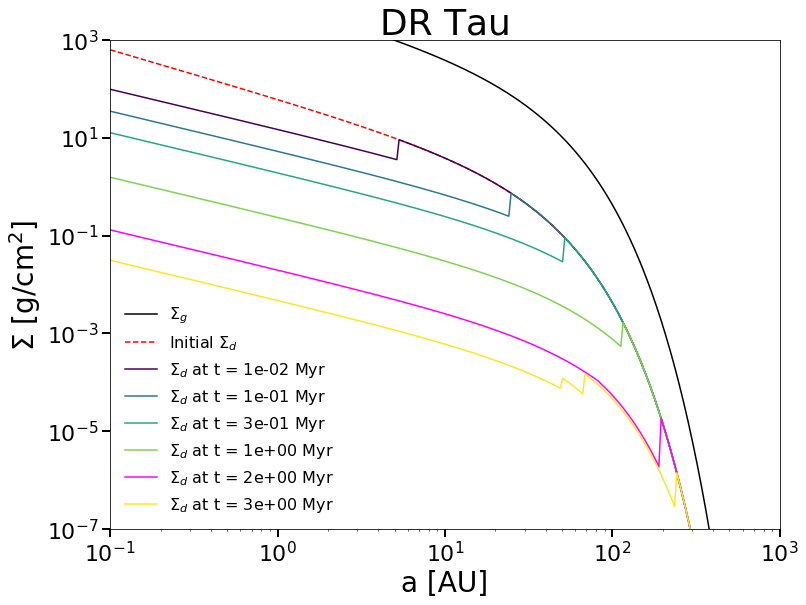

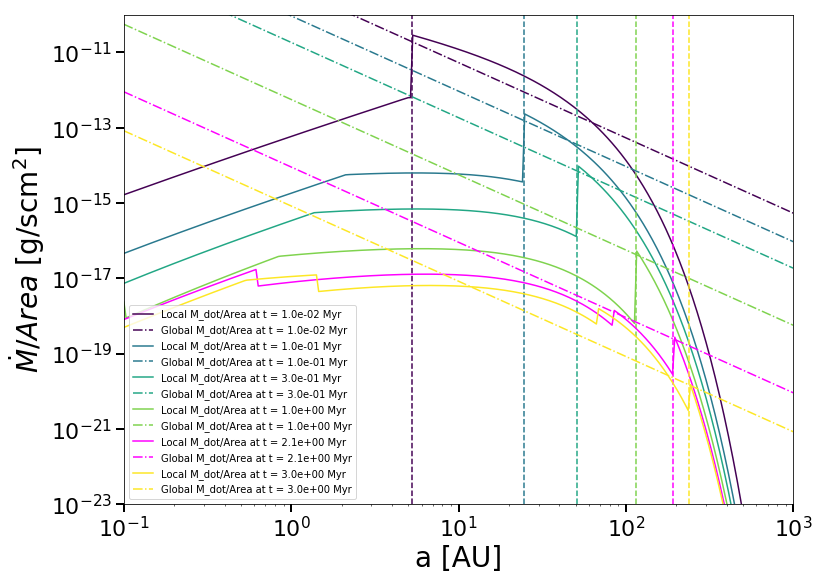

In [3]:
t_array = np.array([0.01, 0.1, 0.3, 1, 2.145, 3]) * 3.154e13
#t_array = np.logspace(-2,0.5, 6) * 3.154e13 # Estimates for DR Tau age range from 0.1 to 3 Myr (1 most common)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 121, 0.8, 315, 20, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb # DR Tau params
#params = 150, 1, 343, 10, 1.6, 4e-4, f_d,  eps_p, eps_d, delt, Lamb # MMSN params
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas

### Creates plot of the surface densities ###
cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
line_colors[4] = 'magenta'

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-' , label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)
    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.0e}"), color=line_colors[i])

plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=28)
plt.xlabel('a [AU]', fontsize=28)
plt.xlim(1e-1,1e3)
plt.ylim(1e-7,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=2)
plt.legend(frameon=False, fontsize=16)
plt.savefig("DR_Tau_SD.pdf")
plt.title("DR Tau", fontsize=36)
plt.show()

### This generates a plot to compare the M_dot per area globally (drifted) vs locally (grown) ###

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = Sig_gas[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/Area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/Area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i], linestyle='-.')
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], linestyle='--')
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=28)
plt.xlabel('a [AU]', fontsize=28)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=2)
plt.xlim(1e-1,1e3)
plt.ylim(1e-23,1e-10)
plt.legend(loc=3)
plt.savefig("Dr_Tau_m_dot.pdf")
plt.show()

In [4]:
# Running model a bunch of times to generate color map for t_grow grid plot
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.logspace(-1,0.5, 6) * 3.154e13 #np.linspace(0.1, 3, 6) * 3.154e13
t_grow_DRTau_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

params = 121, 0.8, 315, 20, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb # DR Tau params
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_Ep = sd[2]

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s_Ep[k,j])
            t_grow_DRTau_arr[k,i,j] = core.t_acc

Transitioned!


/Users/tktakaro/Documents/Pebble_Accretion/Massive_Disks/drag_functions_turb.py:69: RuntimeWarning: divide by zero encountered in double_scalars
  dc = 24./renum*(1+.27*renum)**.43+.47*(1-np.exp(-.04*renum**.38))
/Users/tktakaro/Documents/Pebble_Accretion/Massive_Disks/PebAcc_Turb.py:203: RuntimeWarning: invalid value encountered in double_scalars
  self.delta_a = np.abs(self.f_drag_obj/self.m_obj - self.f_drag_core/self.m_core) # Differential acceleration between core and object
/Users/tktakaro/Documents/Pebble_Accretion/Massive_Disks/PebAcc_Turb.py:305: RuntimeWarning: divide by zero encountered in double_scalars
  self.H_turb = min(np.sqrt(self.alpha_z/self.tau_s) * self.H, self.H) # Turbulent scale height
/Users/tktakaro/Documents/Pebble_Accretion/Massive_Disks/PebAcc_Turb.py:307: RuntimeWarning: divide by zero encountered in double_scalars
  self.H_KH = fn.acc_height(self.H, self.a_core) * self.h_mod * min(1., 1/np.sqrt(self.tau_s))


[167.52524724  21.93497399   3.67466194   0.69632079]


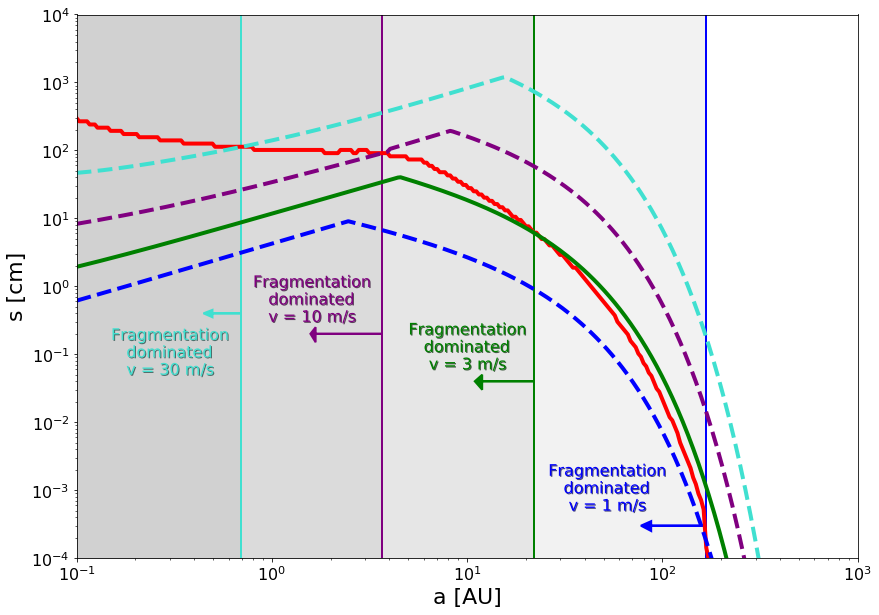

No handles with labels found to put in legend.


47.37893390963144


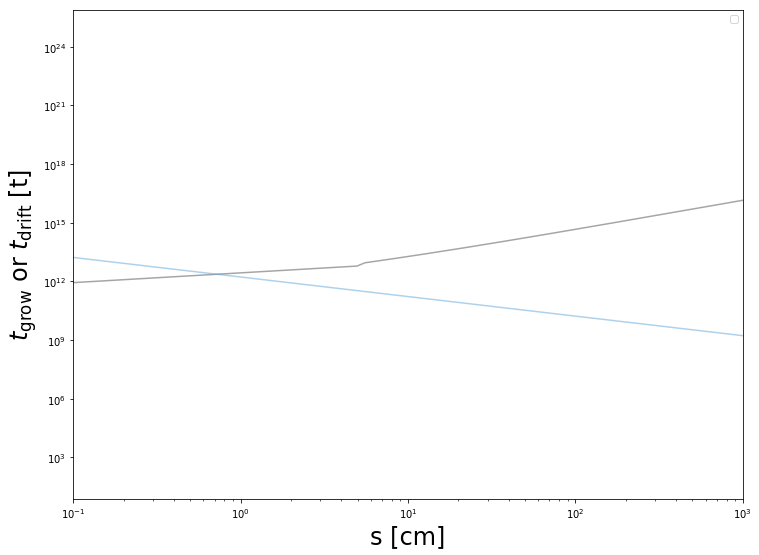

In [5]:
# Try making the max particle size plot for DR Tau, to see where the model applies
v_frag = np.array([1,3,10,30]) *1e2 #1, 3, 10, and 30 m/s
f_f = 0.5 

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros([a_array.size,s_array.size])
t_d_array = np.zeros([a_array.size,s_array.size])
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    Sig = Sig_gas[k]
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        t_g_array[k,i] = t_grow(s, a, f_d, params)
        t_d_array[k,i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array[k] - t_d_array[k]))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[0], alpha=0.10, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[1], alpha=0.10, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[2], alpha=0.10, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[3], alpha=0.10, color='grey')
plt.text(2.6e1,5e-4, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(5e0,6e-2, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(8e-1,3e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.5e-1,5e-2, 'Fragmentation\n   dominated\n   v = 30 m/s', color='turquoise', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 3e-4, -80, 0, linestyle='-', linewidth=2, width=0, head_width=1e-4, head_length=10, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 4e-2, -10, 0, linestyle='-', linewidth=2, width=0, head_width=2e-2, head_length=1, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.2, -2, 0, linestyle='-', linewidth=2, width=0, head_width=0.1, head_length=.1, fc='purple', ec='purple')
plt.axvline(x=frag_loc[3], color='turquoise', linestyle='-', linewidth=2)
plt.arrow(frag_loc[3], 0.4, -0.2, 0, linestyle='-', linewidth=2, width=0, head_width=0.1, head_length=.05, fc='turquoise', ec='turquoise')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.loglog(a_array, s_frag[3], '--', color='turquoise', linewidth=4, label='Fragmentation limited particle size, v = 30 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e3)
plt.ylim(1e-4,1e4)
plt.savefig("DR_Tau_frag.pdf")
print(frag_loc)
plt.show()

fig = plt.figure(1,figsize=(12,9))
k = 200
print(a_array[k])
    #a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    
    #plt.loglog(a_array, sig_d_array[i], label='Solid surface density at t = {time} Myr'.format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
plt.loglog(s_array, t_g_array[k], alpha=0.5)
plt.loglog(s_array, t_d_array[k], alpha=0.5)
    #plt.loglog(a_array, sig_d_arr[1,i], color=line_colors[i])
    
plt.ylabel('$t_\mathrm{grow}$'+' or '+'$t_\mathrm{drift}$ $[\mathrm{t}]$', fontsize=24)
plt.xlabel('s [cm]', fontsize=24)
plt.xlim(1e-1,1e3)
#plt.ylim(1e-7,1e3)
plt.legend()
#plt.savefig("DR_Tau_SD.pdf")
plt.show()

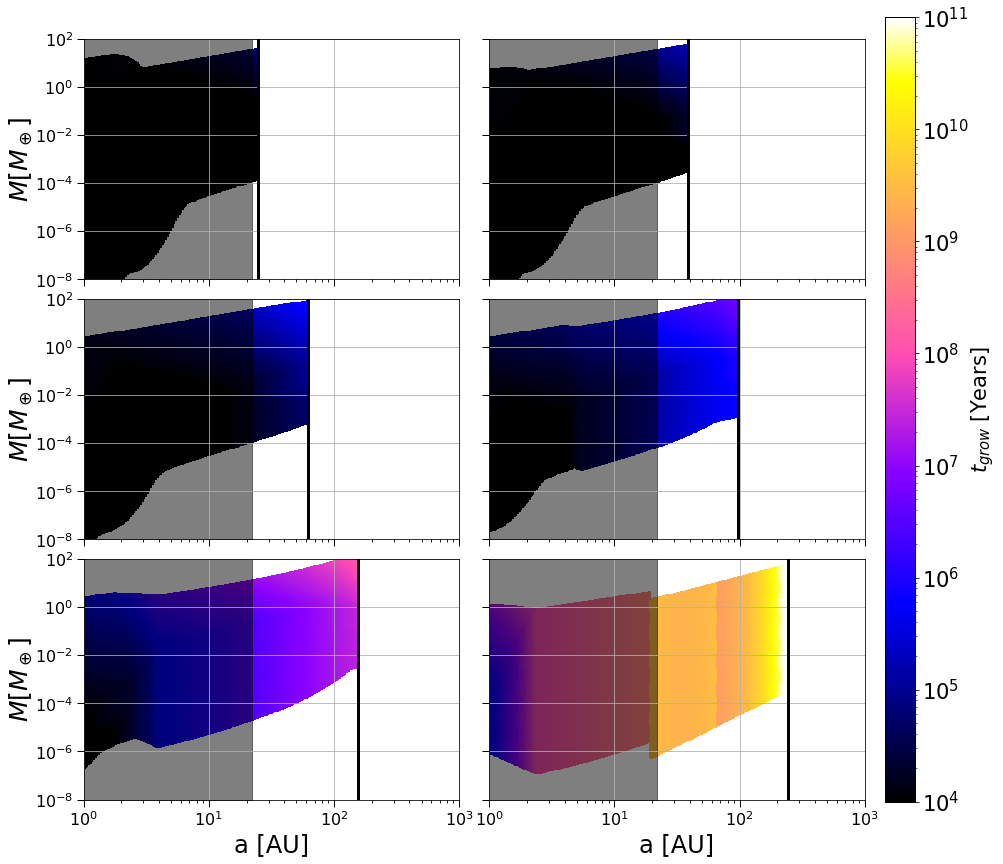

In [13]:
# Try making t_grow grid plot
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.08, hspace=0.08)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_DRTau_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e4,vmax=1e11)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e0, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)
plt.savefig("DR_Tau_tgrow.pdf", bbox_inches = "tight")

## Trying to make the growth efficiency/ratio plot again

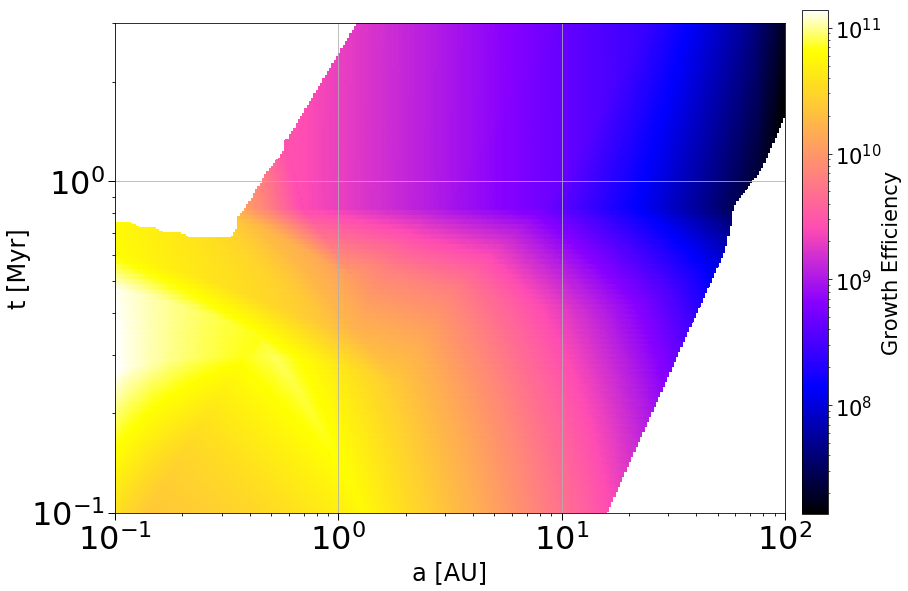

In [17]:
# t_disk gives a_PF
## a_PF plugged into M_flow_iso to get the M_c value
### Use this M_c and a_PF to get a t_grow time
#### Calculate ratio as t_grow/t_reg_lifetime
t_array = np.logspace(-1,0.5, 300) * 3.154e13
a_array = np.logspace(-1, 2, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

M_c_arr = np.zeros([a_array.size, t_array.size])
t_grow_arr = np.zeros([t_array.size, a_array.size])
ratio_arr = np.zeros([t_array.size, a_array.size])
st_arr = np.zeros([a_array.size, t_array.size])
pf_arr = np.zeros([a_array.size, t_array.size])
eps_p = 0.5

### Sets up constants and orbital variables ###
sigma_g = Sig_gas   
T = T_0 * (a_array**(-3/7))
c_s = np.sqrt((boltzmann*T)/(2.35*mH))
Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_array * fn.au)**3)
v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_array * fn.au))
eta = (c_s)**2/(2*(v_kep)**2)
lambda_mfp = fn.mean_free_path(fn.mu, sigma_g/(2*c_s/Om), fn.cross)
Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * Om)

### Find pebble front location  ###
a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au

### Solving for Solid Surface Density ###
a_interior = np.zeros(t_array.size)
s_Ep = np.zeros([t_array.size, a_array.size]) # Particle size
St_Ep = np.zeros([t_array.size, a_array.size])

for i,t in enumerate(t_array):        
    # Check how much of a_arr is inside of pebble front
    a_applicable = np.trim_zeros(np.where(a_array < a_PF[i], a_array, 0))
    Sig = sig_g(a_applicable, sigma_0, params)
    # Set solid surface density inside of pebble front using our version of LJ'14 solution
    #sigma_d[i,:a_applicable.size] = sig_p(f_d, a_PF[i], a_applicable, t, params)
    #sigma_d[i,a_applicable.size:] = f_d * sigma_g[a_applicable.size:] # Outside, set to initial f_d times Sig_g

    # Solve for M_dot from drift at the pebble front
    j_PF = np.argmin(abs(a_applicable - a_PF[i]))
    Sig_p0_PF = f_d*Sig[j_PF]
    M_dot = (4*np.pi)/(3) * (a_PF[i]*fn.au)**2/t * Sig_p0_PF

    # Set max particle size
    for j, a_ind in enumerate(a_array):
        if a_ind < a_PF[i]:
            s_Ep[i,j] = ((3 * Lamb * eps_p)/(8 * delt**2))**(2/5) * (2 * np.pi**7)**(-1/10) * (sigma_g[j]**(3/5) * (M_dot * Om[j])**(2/5)/rho_int) * (v_kep[j]/c_s[j]**2)**(4/5) #((3 * Lamb * eps_p * f_d)/(8 * delt))**(2/3) * (2/np.pi)**(1/6) * (v_kep/c_s)**(4/3) * Sig/rho_int
            St_Ep[i,j] = ((3 * Lamb)/(8 * delt))**2 * (np.pi/4) * ((eps_p * f_d)**2)/(alpha * eta[j])

    # Set orbital variables just inside the pebble front
    T = T_0 * (a_applicable**(-3/7))
    cs = np.sqrt((boltzmann*T)/(2.35*mH))
    v_k = np.sqrt(fn.G * m_star*fn.m_sun/(a_applicable * fn.au))
    v0 = (cs)**2/(2*(v_k)**2) * v_k
    lambda_mfp = fn.mean_free_path(fn.mu, Sig/(2*cs/(v_k/(a_applicable * fn.au))), fn.cross)

    # Calculate the M_dot per area that we want to compare, between global drift and local growth
    St_max = (a_applicable*fn.au)/(2 * v0 * t)
    s_max = np.zeros(St_max.shape)
    for j, St in enumerate(St_max):
        s_max[j] = (St * Sig[j])/(np.sqrt(np.pi/2) * rho_int) #st_solver(st=St, alph=alpha, a_au=a_applicable[j], m_suns=m_star, m_earths=1, temp_in=T[j], sig_in=Sig[j])
    M_dot_loc_specific = dust_to_gas(t, a_PF[i], a_applicable, params)*Sig/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_applicable*fn.au)**2)

    # Now, compare the local (growth) M_dot to the global (drift) M_dot, calculated at the pebble front
    if np.amax(M_dot_loc_specific - M_dot_glo_specific) > 0:
        # Local growth sets the size of particles, so we're in Powell et al. 2017 regime
        # Find location in disk where local M_dot is greatest 
        j = np.argmax(M_dot_loc_specific - M_dot_glo_specific) #np.argmax(t_grow_arr)

        # Define disk edge
        if a_interior[i-1] != 0: # If this isn't the first time step where we're calculating an inner pebble front
            a = a_interior[i-1] # Set a to be the last inner a_PF
            j = np.argmin(abs(a - a_applicable)) # Pull the index of this inner a_PF
        else:
            # Sets the first inner a_PF to be the location of max local growth inside of a_PF
            # This is the location at which the M_dot transition occurs
            a = a_applicable[j]
            st_edge = St_max[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
            t_edge = 0.99 * t # Modified to give non-zero time to drift the 1st time

        # Calculate location to which largest particles have drifted
        v_drift = - 2 * v0[j] * (st_edge/(1 + st_edge**2))
        t_old = max(t_edge, t_disk[i-1])

        # Set this location to which the largest particle has drifted. Doesn't use 0, bc of earlier check
        a_interior[i] = np.maximum(a - abs((t - t_old) * v_drift)/fn.au, 0.0001)

        # Find the index in a_applicable closest to a_interior[i], then only update from k on
        k = np.argmin(abs(a_interior[i] - a_applicable)) # Pull the index of this innermost a_PF
        # Apply Powell regime from k on, leaving LJ'14 regime from 0 to k
        #sigma_d[i,k:a_applicable.size] = dust_to_gas(t, a_PF[i], a_applicable[k:], params) * Sig[k:]
        # Apply Powell regime for the particle size as well
        s_Ep[i,k:a_applicable.size] = s_max[k:a_applicable.size]
        St[i,k:a_applicable.size] = St_max[i,k:a_applicable.size]

"""
a_interior = np.zeros(t_array.size)
t_drift_arr = np.zeros([t_array.size, a_array.size])
for i, t in enumerate(t_array):
    # Find pebble front location
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    t_edge = np.array([(16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2), 3*3.154e13])
    
    sig_d = surface_density(a_array, t_edge, params)[1][0]
    T = T_0 * (a_array**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_array * fn.au)**3)
    v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_array * fn.au))
    eta = (c_s)**2/(2*(v_kep)**2)
    #St = (a_array*fn.au)/(2 * eta*v_kep * t_edge[0]) # Solve for max particle size at pebble front
    St = np.sqrt(3)/8 * eps_p/eta * sig_d/Sig_gas # Max particle size for all a, at t=t_edge
    if a_PF > a_edge:
        # If in Powell et al. 2017 regime, find drift time for maximally size particle
        if a_interior[i-1] != 0:
            a = a_interior[i-1]
        else: a = a_edge
        j = np.argmin(abs(a - a_array))
        gamma = 1.0
        Sig = sig_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
        T = T_0 * (a**(-3/7))
        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
        eta = (c_s)**2/(2*(v_kep)**2)
        v0 = eta * v_kep
        v_drift = - 2 * v0 * (St[j]/(1 + St[j]**2))
        if i != 0:
            t_old = max(t_edge[0], t_array[i-1])
            t_diff = t - t_old
        else: t_diff = 0
            
        j = np.argmin(abs(a_edge - a_array))
        st_edge = St[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
        s_edge = st_solver(st=st_edge, alph=alpha, a_au=a_edge, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
        #print("Particle size is ", s_edge, "cm")
        t_diff_arr = np.linspace(t_old, t, 1000)
        a_diff_arr = np.zeros(t_diff_arr.size)
        for k, t_d in enumerate(t_diff_arr):
            if k == 0:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            else:
                T = T_0 * (a_new**(-3/7))
                c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                v0 = eta * v_kep
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
            if k == 0:
                a_diff_arr[k] = v_drift * (t_diff_arr[k+1] - t_d) / fn.au
                a_drifted = abs(a_diff_arr[k])
                a_new = a - a_drifted
            else:
                a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                a_drifted = a_drifted + abs(a_diff_arr[k])
                a_new = a - a_drifted
        # Finds the locations to which maximally sized particles have drifted by new disk time
        a_interior[i] = a_new
"""
        
for j,a_au in enumerate(a_array):
    for i,t in enumerate(t_array):
        # Uses the time-evolving surface densities created above
        sig_gas = Sig_gas
        sig_d = sig_d_array[i]

        # Sets the pebble front location (in AU)
        a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
        pf_arr[j,i] = a_PF
        #a_au = 10 # Chooses a semi-major axis
        a = a_au * fn.au # Converts to cm
        a_au_ind = np.argmin(abs(a_au - a_array)) # WTF? ISN'T THIS JUST j

        # Calculates disk properties
        temp = T_0*a_au**(-3./7.)
        c_s = fn.sound_speed(temp)
        v_k = fn.vkep(m_star*fn.m_sun, a)
        eta = fn.eta(c_s, v_k)
        v_0 = eta * v_k
        v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)

        ## Calculates max particle size
        #tau_f = np.sqrt(3)/8 * (eps_p * sig_d[a_au_ind])/(eta * sig_gas[a_au_ind])
        ##if a_PF > a_edge and a > a_interior[i]: # If in 3rd regime (Diana's)
        #if a_interior[i] != 0 and a > interior[i]:
        #    St = (a)/(2 * v_g * t)
        #else: # If in 2nd regime (LJ14's)
        #    St = tau_f
        #st_arr[j,i] = St
        
        # Calculates flow isolation mass
        H = (c_s * a)/v_k
        term1 = np.sqrt(St_Ep[i,j])
        term2 = 1
        term3 = (c_s/v_0 * St_Ep[i,j])
        min1 = np.minimum(term1, term2)
        pre_fac = np.minimum(min1, term3)
        M_c_arr[j,i] = (H/a)**3 * 3e5 * pre_fac

        # Runs pebble accretion model
        #s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=M_c_arr[j,i], temp_in=temp, sig_in=sig_gas[a_au_ind])
        #core = Core(a_core_au=a_PF, m_core_earthmasses=M_c_arr[j,i], alpha=alpha, m_star_solarmasses=m_star,
                    #temp_in=temp, sig_p_in=sig_d[a_au_ind], sig_g_in=sig_gas[a_au_ind])
        core = Core(a_core_au=a_PF, m_core_earthmasses=M_c_arr[j,i], alpha=alpha, m_star_solarmasses=m_star,
                temp_in=temp, sig_p_in=sig_d[j], sig_g_in=sig_gas[j])
        core.main(s_Ep[i,j])
        t_grow_arr[i,j] = core.t_acc

        # Measures time spent in disk regime
        #t_edge = (3/16)**(-1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (np.amax(a_array) * fn.au)**(3/2)
        if t_grow_arr[i,j] == 0:
            ratio_arr[i,j] = 0
        elif a_PF > np.amax(a_array):
            t_dissipation = 3 * 3.154e13 # 3 Myr
            ratio_arr[i,j] = t_array[-1]/t_grow_arr[i,j] #t_grow_arr[i,j]/(t - t_edge)
        else:
            t_start = (3/16)**(-1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_au * fn.au)**(3/2)
            ratio_arr[i,j] = t_array[-1]/t_grow_arr[i,j] #t_grow_arr[i,j]/(t - t_start)
            
t_PF_arr = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_array * fn.au)**(3/2)

fig = plt.figure(1,figsize=(12,9))
X, Y = np.meshgrid(a_array, t_array/3.154e13)
im = plt.pcolormesh(X,Y,ratio_arr, cmap=cmap,norm=LogNorm())#,vmax=1e10)
plt.grid()

im.set_edgecolor('face')
ax = plt.gca()
#plt.loglog(a_array, t_PF_arr/3.154e13, 'r--')
ax.tick_params(which='major', length=7,width=1.0)
ax.tick_params(which='minor', length=3.0,width=0.85)
ax.set_xlabel('a [AU]',fontsize=24)
ax.set_ylabel('t [Myr]',fontsize=24)
ax.set_ylim(1e-1,3e0)
ax.set_xlim(1e-1, 1e2)
ax.set_xscale('log')
ax.set_yscale('log')
plt.xticks(**tick_font)
plt.yticks(**tick_font)

#ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
#ax.fill_betweenx(m_core_arr, 1e-1, frag_loc, alpha=0.5)
cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
#cb.set_label(label=r'Ratio of $t_\mathrm{grow}$ to regime lifetime',fontsize=21,labelpad=0.1)
cb.set_label(label='Growth Efficiency',fontsize=21,labelpad=0.1)
cb.ax.tick_params(labelsize=21)
plt.savefig('DRTau_eff.pdf', bbox_inches = "tight")
plt.show()

# Trying the model on new disks

In [65]:
print(np.logspace(-1,0.5,6)) # For DR Tau, AS 209, FT Tau, CY Tau, DoAr 25
print(np.logspace(-1,0.7,6)) # For HD 163296
print(np.logspace(-1,1,6)) # For TW Hya

[0.1        0.19952623 0.39810717 0.79432823 1.58489319 3.16227766]
[0.1        0.21877616 0.47863009 1.04712855 2.29086765 5.01187234]
[ 0.1         0.25118864  0.63095734  1.58489319  3.98107171 10.        ]


## TW Hya

Transitioned!
Transitioned!


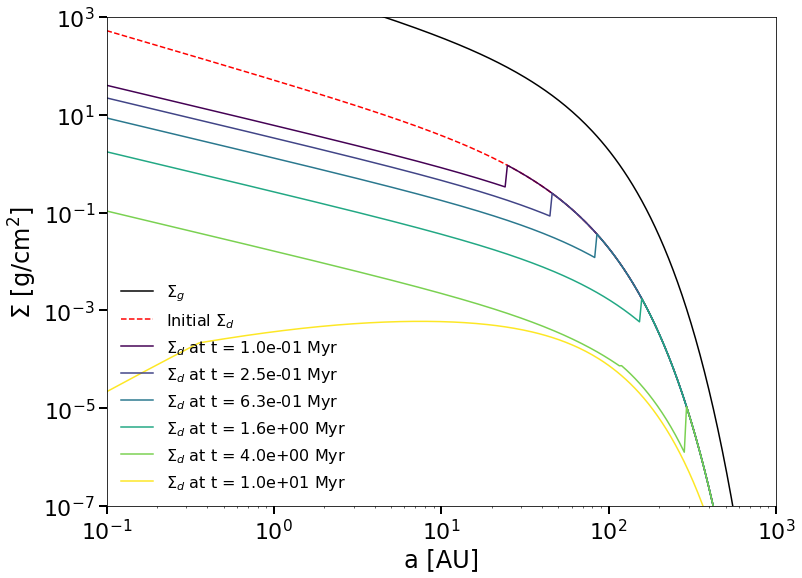

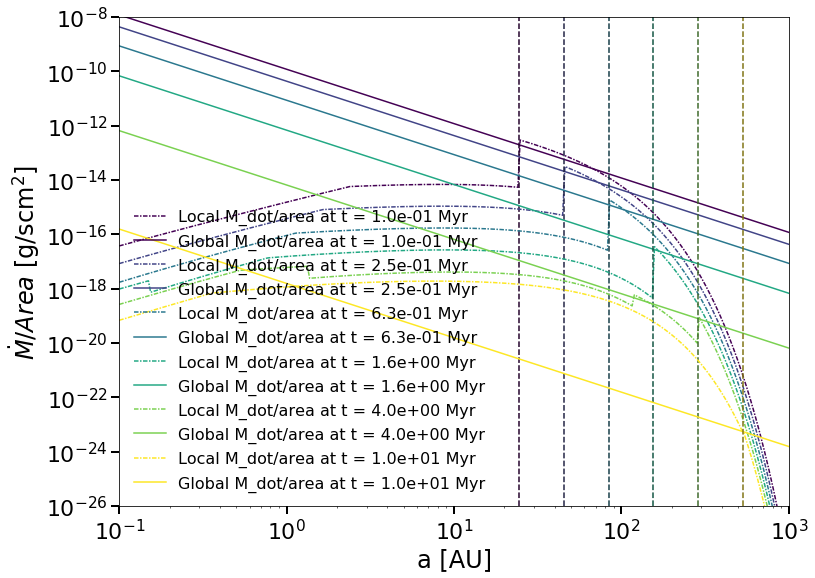

In [100]:
t_array = np.logspace(-1,1, 6) * 3.154e13 # TW Hya's age is estimated at 5 Mya, from 3 to 10 range (Powell 2019 has 2 references to pull for this)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 82, 0.8, 175, 30, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas

### Creates plot of the surface densities ###
cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)
    #plt.loglog(a_array, sig_d_LJ[i], label="LJ'14 surface density at t = {time} Myr".format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    
    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[0,i], color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[1,i], color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.xlim(1e-1,1e3)
plt.ylim(1e-7,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=2)
plt.legend(frameon=False, fontsize=16, loc=3)
plt.savefig("TW_Hya_SD.pdf")
plt.show()



### This generates a plot to compare the M_dot per area globally (drifted) vs locally (grown) ###

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = Sig_gas[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i], linestyle=(0,(3,1,1,1)))
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.axvline(x=a_PF_arr[i], color='k', linestyle='--', alpha=0.8)
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], linestyle='--', alpha=0.5)
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-26,1e-8)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=2)
plt.legend(frameon=False, fontsize=16)
plt.savefig("TW_Hya_m_dot.pdf")
plt.show()

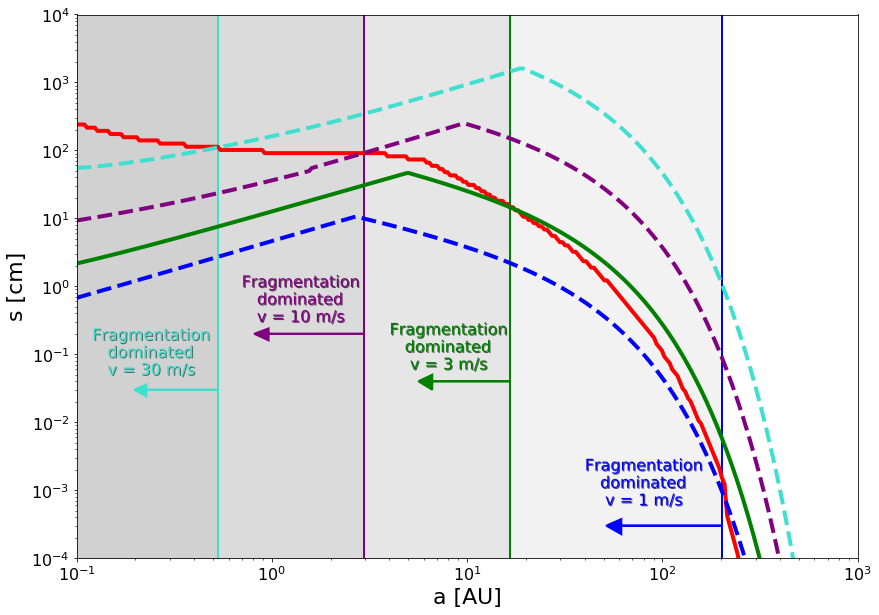

In [21]:
# Try making the max particle size plot for TW Hya, to see where the model applies
v_frag = np.array([1,3,10,30]) *1e2 #1, 3, 10, and 30 m/s
f_f = 0.5 

#params = [T_0, m_star, sig_0, r_crit, rho_int, 1e-5, a_edge]

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    Sig = Sig_gas[k]
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]
    
import matplotlib.patheffects as path_effects

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[0], alpha=0.10, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[1], alpha=0.10, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[2], alpha=0.10, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[3], alpha=0.10, color='grey')
plt.text(4e1,6e-4, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(4e0,6e-2, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(7e-1,3e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(1.2e-1,5e-2, 'Fragmentation\n   dominated\n   v = 30 m/s', color='turquoise', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 3e-4, -140, 0, linestyle='-', linewidth=2, width=0, head_width=1.5e-4, head_length=10, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 4e-2, -10, 0, linestyle='-', linewidth=2, width=0, head_width=2e-2, head_length=1, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.2, -2, 0, linestyle='-', linewidth=2, width=0, head_width=0.08, head_length=.15, fc='purple', ec='purple')
plt.axvline(x=frag_loc[3], color='turquoise', linestyle='-', linewidth=2)
plt.arrow(frag_loc[3], 3e-2, -.3, 0, linestyle='-', linewidth=2, width=0, head_width=0.012, head_length=.03, fc='turquoise', ec='turquoise')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.loglog(a_array, s_frag[3], '--', color='turquoise', linewidth=4, label='Fragmentation limited particle size, v = 30 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e3)
plt.ylim(1e-4,1e4)
plt.savefig("TW_Hya_frag.pdf")

Transitioned!
Transitioned!


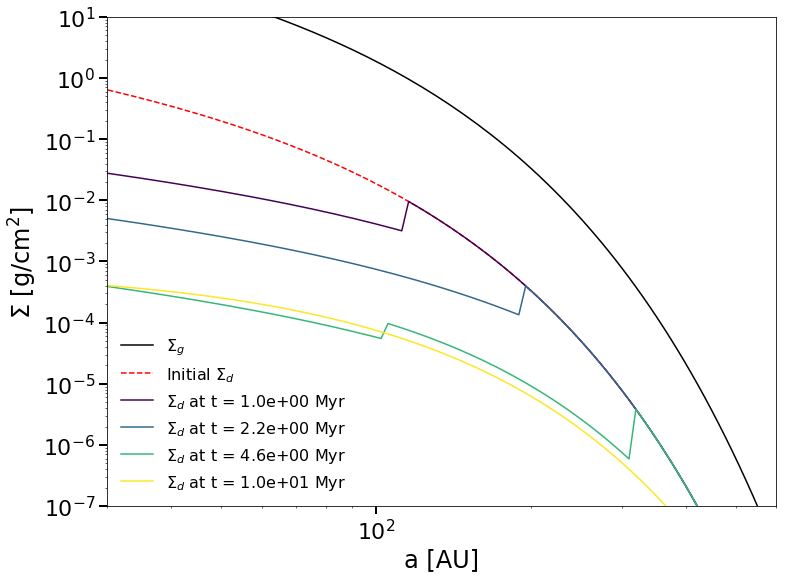

In [22]:
### Creates zoomed in surface density plot, and max particle size plot ###
t_array = np.logspace(0,1, 4) * 3.154e13 # TW Hya's age is estimated at 5 Mya, from 3 to 10 range (Powell 2019 has 2 references to pull for this)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 82, 0.8, 175, 30, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    
    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-7,1e1)
plt.xlim(3e1,6e2)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=2)
plt.legend(frameon=False, fontsize=16)
plt.savefig("TW_Hya_SD_zoom.pdf")
plt.show()

In [23]:
# Running model a bunch of times to generate color map for t_grow grid plot
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.logspace(-1,1, 6) * 3.154e13 #np.linspace(0.1, 3, 6) * 3.154e13
t_grow_TWHya_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_Ep = sd[2]

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s_Ep[k,j])
            t_grow_TWHya_arr[k,i,j] = core.t_acc

Transitioned!
Transitioned!


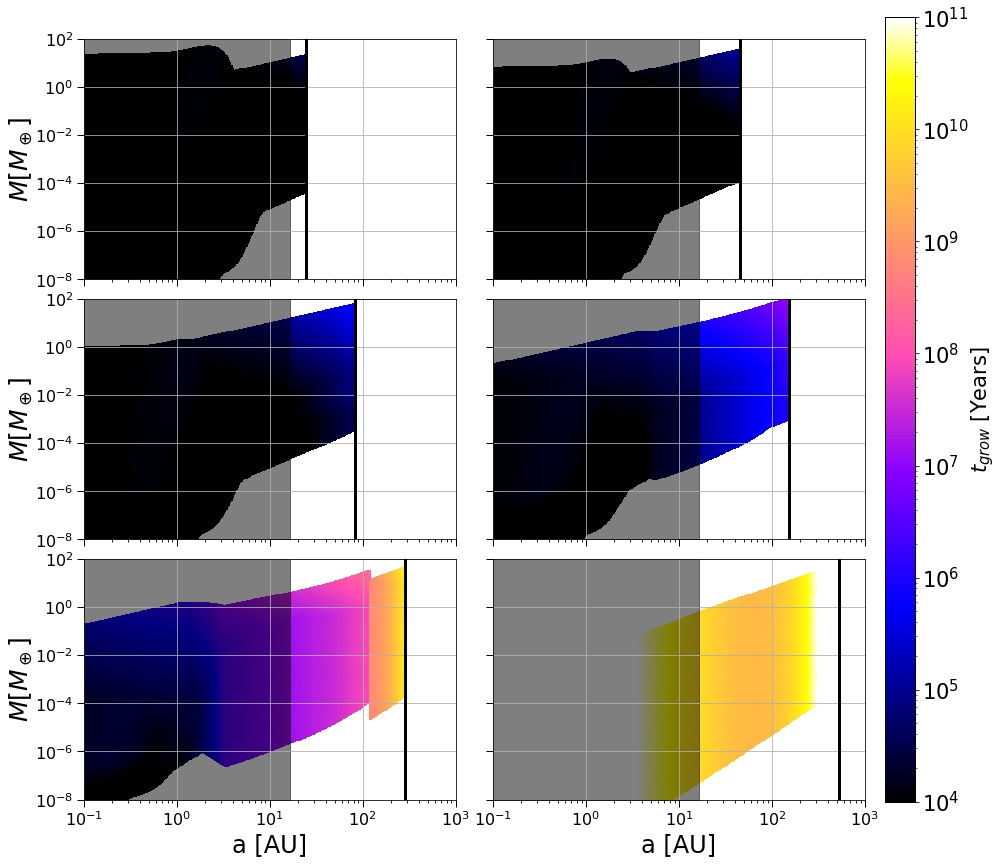

In [25]:
# Try making t_grow grid plot
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.08)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_TWHya_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e4,vmax=1e11)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)
plt.savefig("TW_Hya_tgrow.pdf", bbox_inches = "tight")

In [15]:
# Now, let's try the integrated mass plot
def rate_odeint(m,t,p):
    a_au, sig_g, sig_p, s, params = p
    T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params
    #alph,a_au,m_suns,temp,sig_gas,sig_p,st,verbose = p

    T = T_0 * (a_au**(-3/7))
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((fn.G*m_star*fn.m_sun)/(a_au*fn.au)**3.)
    v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
    v0 = fn.eta(c_s, v_k) * v_k
    H_g = c_s/Om
    
    m_earths = m/fn.m_earth
    
    #st = (a_au*fn.au)/(2 * v_g * t)
    #s = st_solver(st=st,alph=alph,a_au=a_au,sig_in=sig_gas,temp_in=temp,m_earths=m_earths)
    
    st = st_rad(rad=s,alph=alpha,a_au=a_au,m_suns=m_star,m_earths=m_earths,sig_in=sig_g,temp_in=T)
    m = 4./3 * np.pi * rho_int * s**3
    
    if np.isnan(s) or s < 0 or m < 0:
        print("Bad radius/mass")
        s = np.abs(s)
        m = np.abs(m)
        
    # Calculates flow isolation mass
    term1 = np.sqrt(st)
    term2 = 1
    term3 = (c_s/v_g * st)
    min1 = np.minimum(term1, term2)
    pre_fac = np.minimum(min1, term3)
    M_flow = (H_g/(a_au*fn.au))**3 * pre_fac * fn.m_sun
    B = 2*np.sqrt(3)
    M_iso = (4 * np.pi * B * (a_au*fn.au)**2 * sig_p)**(3/2) / (3 * m_star*fn.m_sun)**(1/2) # GF isolation mass
    M_peb_iso = 20 * fn.m_earth * (H_g/(a_au*fn.au)/0.05)**3
    m_iso = min(M_iso, M_peb_iso)
    
    rp = (3*m/(4. * np.pi * rho_int))**(1./3.) # Core radius
    v_esc = np.sqrt(2*fn.G*m/rp)

    H_turb = np.sqrt(alpha/(alpha+st))*H_g
    H_KH = 2*v0/Om
    H_p = max(H_turb,H_KH)
    rho_solid = sig_p/2./H_p
    v_turb = np.sqrt(alpha)*c_s/np.sqrt(1 + st)
    v_lam = v0*np.sqrt(1 + 4.*st**2.)/(1 + st**2.)
    v_inf = max(v_turb,v_lam)
    bGF = rp*(1 + (v_esc/v_inf)**2.)**(0.5)
    H_acc = min(H_p,bGF)
    sig_acc = 4*bGF*H_acc
    rate_GF = rho_solid*sig_acc*v_inf

    core = Core(a_core_au=a_au, m_core_earthmasses=m_earths, alpha=alpha, m_star_solarmasses=m_star, temp_in=T,
                sig_p_in=sig_p, sig_g_in=sig_g)
    core.main(s)
    
    # Trying out a loop to tests growth with particles smaller than maximally sized
    t_acc = core.t_acc
    count = 0
    while t_acc == 0:
        core.main(.9*s)
        t_acc = core.t_acc
        count = count + 1
        if count >= 10:
            break
    if t_acc == 0:
        rate_peb = rate_GF
    else:        
        rate_peb = m/(core.t_acc*3.154e7)
    r_ws = core.r_ws
    h_r = core.r_hill
    b_r = core.r_bondi
    b_shear = core.r_sh
    r_tmp = min(r_ws,b_shear)
    r_stab = min(r_tmp,h_r)
    if bGF > r_stab:
        if m > M_iso:
            if m > M_flow:
                return 0
            else:
                rate = rate_peb
                if np.isinf(rate_peb):
                    if verbose: print("Pebble accretion is off")
                    return 0
        else:
            rate = rate_GF
        if np.isinf(rate_GF):
            print("Gravitational Focusing is broken")
    else:
        if m > M_flow:
            return 0
        rate = rate_peb
        if np.isinf(rate_peb):
            if verbose: print("Pebble accretion is off")
            rate = rate_GF
    return abs(rate)

In [16]:
# Try integrating core masses as the disk evolves
m0_arr = np.multiply([1e-1,1e-2,1e-3,1e-4,1e-5,1e-6,1e-7],fn.m_earth)
t_array = np.logspace(-1,0.5, 100) * 3.154e13
a_array = np.array([1,3,5,10,30,100])

sig_d_array = np.zeros([t_array.size, a_array.size])
params = 82, 0.8, 175, 30, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_max = sd[2]

n_int = 1000 # Number of internal integrations between disk evolution time-steps
m_arr = np.zeros((len(a_array), len(m0_arr), n_int*len(t_array)))


for i,a_au in enumerate(a_array):
    sig_gas = Sig_gas[i]
    temp = T_0*a_au**(-3./7.)
    c_s = fn.sound_speed(temp)
    v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
    v_0 = fn.eta(c_s, v_k) * v_k
    v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
    for j,m0 in enumerate(m0_arr):
        for k,t in enumerate(t_array):
            if k == 0:
                mass = m0
                m_final = m0
            else:
                mass = m_final
            m_earths = mass/fn.m_earth
            st = st_rad(rad=s_max[k,i],alph=alpha,a_au=a_au,m_suns=m_star,m_earths=m_earths,sig_in=sig_gas,temp_in=temp) #(a_au*fn.au)/(2 * v_g * t)
            
            if k == 99:
                times = np.logspace(np.log10(t),np.log10(t + (t - t_array[k-1])),n_int) #np.linspace(t,t + (t - t_array[-2]),100)
            else:
                times = np.logspace(np.log10(t),np.log10(t_array[k+1]),n_int) #np.linspace(t,t_array[k+1],100)
                #a_au, sig_g, sig_p, s, params = p
            p = [a_au, sig_gas, sig_d_array[k,i], s_max[k,i], params] #[alpha,a_au,m_star,temp,sig_gas,sig_d_array[k,i],st,0]
            wsol = odeint(rate_odeint,mass,times,args=(p,))
            m_arr[i,j,n_int*k:n_int*k+n_int] = wsol.flatten()
            m_final = max(m_final, wsol.flatten()[-1])

GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BROKEN RESULTS
GIVING BRO

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:40: RuntimeWarning: invalid value encountered in double_scalars


[[5.976e+26       nan       nan ...       nan       nan       nan]
 [5.976e+25       nan       nan ...       nan       nan       nan]
 [5.976e+24       nan       nan ...       nan       nan       nan]
 ...
 [5.976e+22       nan       nan ...       nan       nan       nan]
 [5.976e+21       nan       nan ...       nan       nan       nan]
 [5.976e+20       nan       nan ...       nan       nan       nan]]


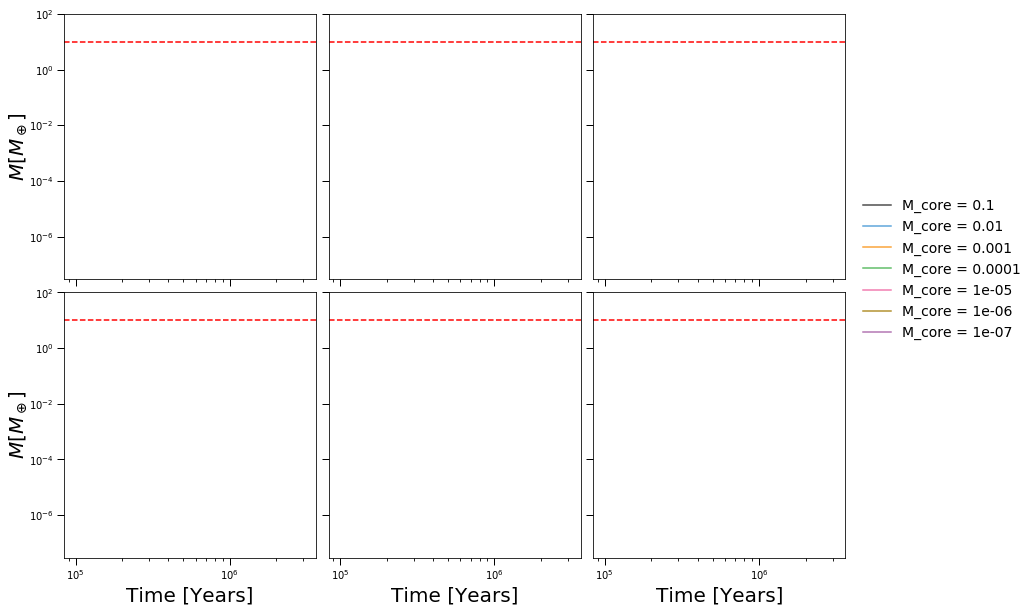

In [17]:
fig = plt.figure(figsize=(14,10))
plt.title(r'$\alpha = 1 \times 10^{-6}, \, St = \frac{a}{2 v_{g} t_\mathrm{disk}}$',y=1.01)
gs = gridspec.GridSpec(2, 3)
gs.update(wspace=0.05, hspace=0.05)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}
t_array = np.logspace(-1,0.5, 100000) * 3.154e13

ax0 = plt.subplot(gs[0,0])
ax1 = plt.subplot(gs[0,1])
ax2 = plt.subplot(gs[0,2])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])
ax5 = plt.subplot(gs[1,2])

for i in range(len(m0_arr)):
    ax0.loglog(t_array*fn.sec_to_years,m_arr[0,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax1.loglog(t_array*fn.sec_to_years,m_arr[1,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax2.loglog(t_array*fn.sec_to_years,m_arr[2,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax3.loglog(t_array*fn.sec_to_years,m_arr[3,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax4.loglog(t_array*fn.sec_to_years,m_arr[4,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))
    ax5.loglog(t_array*fn.sec_to_years,m_arr[5,i]/fn.m_earth, label='M_core = {core_mass}'.format(core_mass=f"{m0_arr[i]/fn.m_earth:.2n}"))

for i in range(6):
    if i == 0:ax = ax0
    if i == 1: ax = ax1
    if i == 2: ax = ax2
    if i == 3: ax = ax3
    if i == 4: ax = ax4
    if i == 5: ax = ax5
    
    if i == 3 or i == 4 or i == 5:
        ax.set_xlabel('Time [Years]',fontsize=20)
    else:
        ax.tick_params(labelbottom=False) 
    if i == 0 or i == 3:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=20,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    
    ax.axhline(y=1e1,linestyle='dashed',color='r')
    ax.set_ylim(3e-8,1e2)
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)

lgd = plt.gca().legend(bbox_to_anchor=[1.02,1.4],frameon=False, fontsize=14)

plt.tight_layout()
print(m_arr[0])

## AS 209

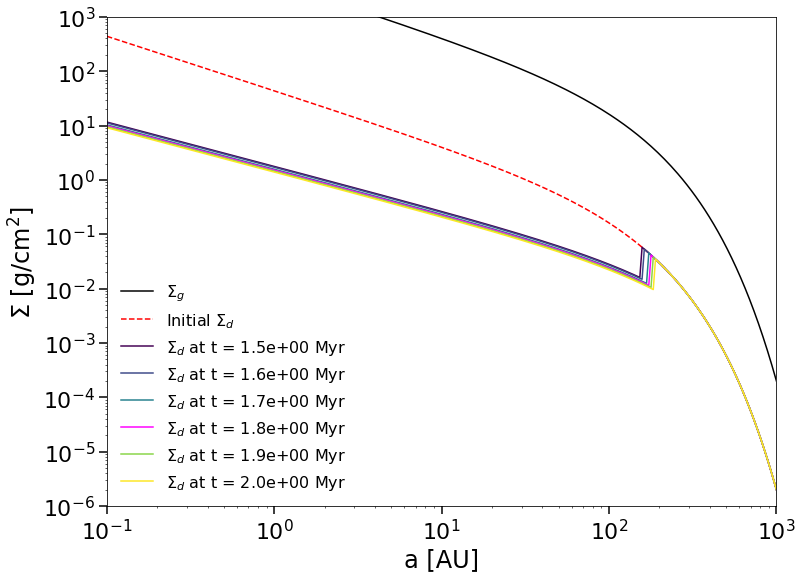

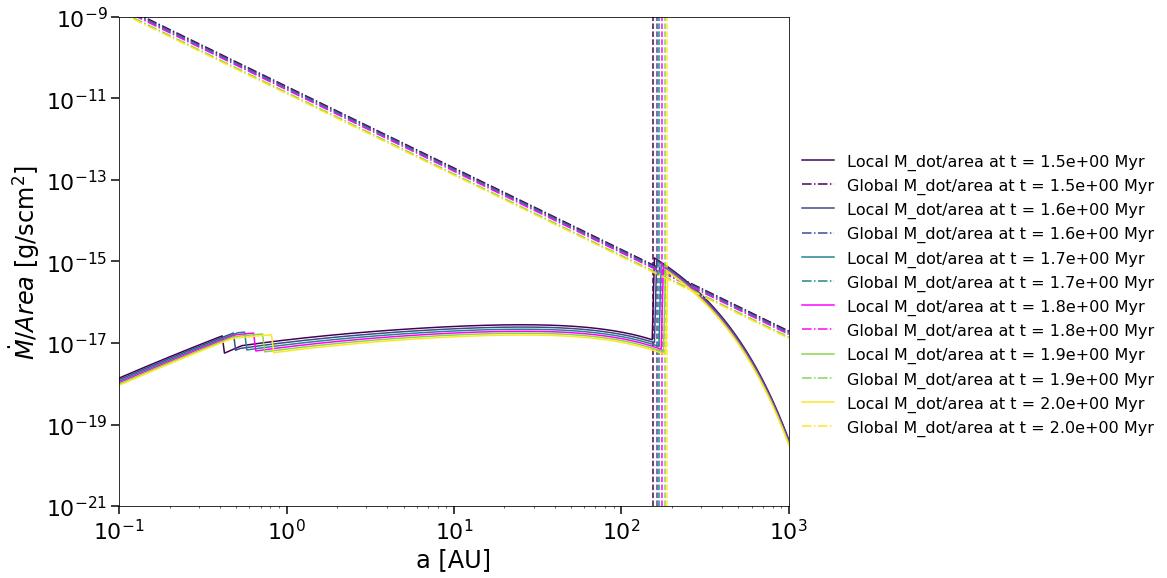

In [107]:
#t_array = np.array([0.01, 0.1, 1, 1.6, 3, 10]) * 3.154e13
t_array = np.array([1.5,1.6,1.7,1.8,1.9,2]) * 3.154e13
#t_array = np.logspace(-2,0.2, 6) * 3.154e13 # AS 209's age is estimated at 1.6 Mya, but note down to 0.5 (Powell 2019 has 3 references to pull for this)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 131, 0.9, 44, 100, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas

### Creates plot of the surface densities ###
cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
# Select the current age estimate and make it magenta
line_colors[3] = 'magenta'

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)

    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-6,1e3)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16)
plt.savefig("AS_209_SD.pdf")
plt.show()



### This generates a plot to compare the M_dot per area globally (drifted) vs locally (grown) ###

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = Sig_gas[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i], linestyle='-.')
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], linestyle='--')
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.xlim(1e-1,1e3)
plt.ylim(1e-21,1e-9)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16, loc=(1.01,0.13))
plt.savefig("AS_209_M_dot.pdf", bbox_inches = "tight")
plt.show()

In [108]:
# Running model a bunch of times to generate color map for t_grow grid plot
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
#t_array = np.logspace(-1,0.5, 6) * 3.154e13 #np.linspace(0.1, 3, 6) * 3.154e13
t_grow_209_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_Ep = sd[2]

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s_Ep[k,j])
            t_grow_209_arr[k,i,j] = core.t_acc

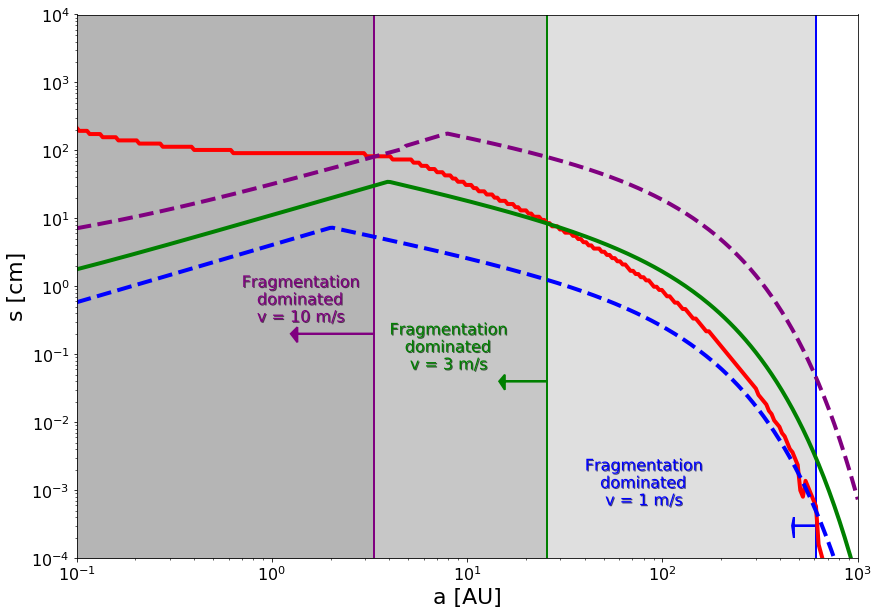

In [36]:
# Try making the max particle size plot for TW Hya, to see where the model applies
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    Sig = Sig_gas[k]
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(4e1,6e-4, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(4e0,6e-2, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(7e-1,3e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 3e-4, -140, 0, linestyle='-', linewidth=2, width=0, head_width=2e-4, head_length=10, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 4e-2, -10, 0, linestyle='-', linewidth=2, width=0, head_width=2e-2, head_length=1, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.2, -2, 0, linestyle='-', linewidth=2, width=0, head_width=0.1, head_length=.1, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e3)
plt.ylim(1e-4,1e4)
plt.savefig("AS_209_frag.pdf", bbox_inches = "tight")

fig = plt.figure(1,figsize=(14,10))
#plt.loglog(a_array,t_)

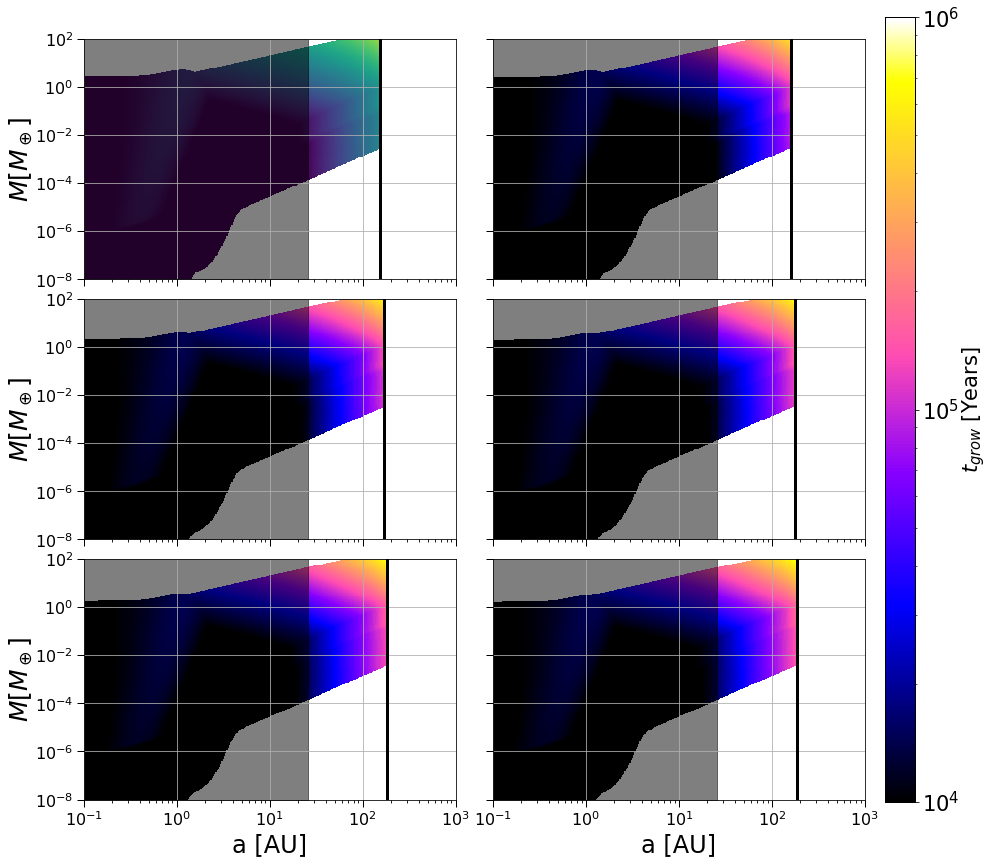

In [109]:
# Try making t_grow grid plot
# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.08)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_209_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e4,vmax=1e6)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)
#plt.savefig("AS_209_tgrow.pdf", bbox_inches = "tight")

## HD 163296

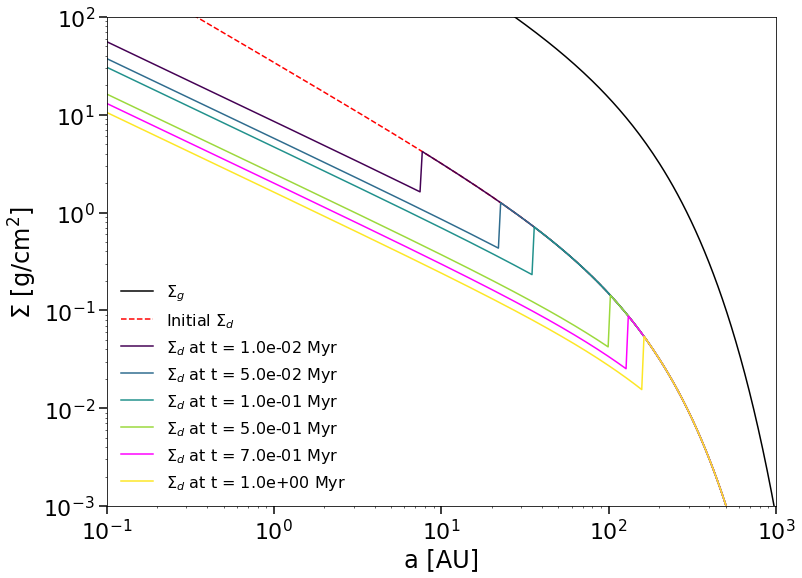

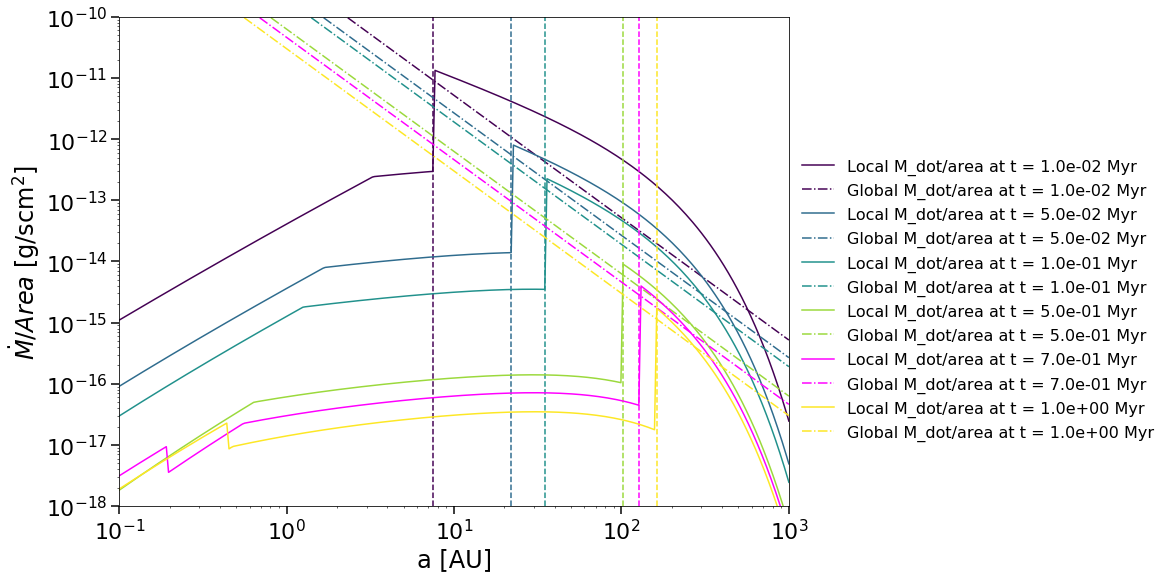

In [44]:
t_array = np.array([0.01, 0.05, 0.1, 0.5, 0.7, 1]) * 3.154e13
#t_array = np.logspace(-2,0.7, 12) * 3.154e13 # HD 163296's age is estimated at 5 Mya, from 3+ range (Powell 2019 has 2 references to pull for this)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 284, 2.3, 29, 119, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas

### Creates plot of the surface densities ###
cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
# Select the current age estimate and make it magenta
line_colors[4] = 'magenta'

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)
    #plt.loglog(a_array, sig_d_LJ[i], label="LJ'14 surface density at t = {time} Myr".format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    
    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[0,i], color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[1,i], color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-3,1e2)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16)
plt.savefig("HD_163_SD.pdf")
plt.show()



### This generates a plot to compare the M_dot per area globally (drifted) vs locally (grown) ###

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = Sig_gas[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i], linestyle='-.')
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], linestyle='--')
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-18,1e-10)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16, loc=(1.01,0.12))
plt.savefig("HD_163_M_dot.pdf", bbox_inches = "tight")
plt.show()

In [45]:
# Running model a bunch of times to generate color map for t_grow grid plot
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.logspace(-1,0.7, 6) * 3.154e13 #np.linspace(0.1, 3, 6) * 3.154e13
t_grow_163_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_Ep = sd[2]

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s_Ep[k,j])
            t_grow_163_arr[k,i,j] = core.t_acc

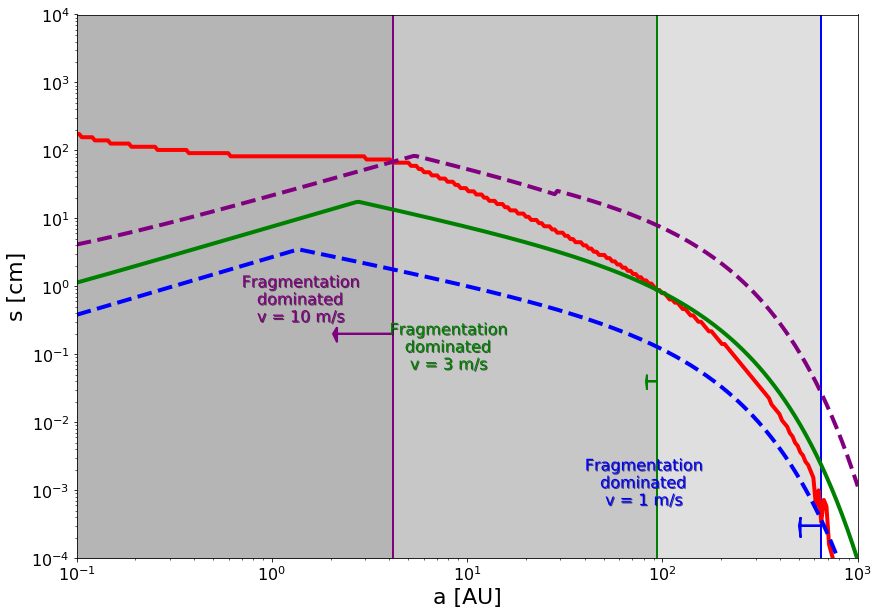

In [46]:
# Try making the max particle size plot for TW Hya, to see where the model applies
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    Sig = Sig_gas[k]
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(4e1,6e-4, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(4e0,6e-2, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(7e-1,3e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 3e-4, -140, 0, linestyle='-', linewidth=2, width=0, head_width=2e-4, head_length=10, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 4e-2, -10, 0, linestyle='-', linewidth=2, width=0, head_width=2e-2, head_length=1, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.2, -2, 0, linestyle='-', linewidth=2, width=0, head_width=0.1, head_length=.1, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e3)
plt.ylim(1e-4,1e4)
plt.savefig("HD_163_frag.pdf", bbox_inches = "tight")

fig = plt.figure(1,figsize=(14,10))

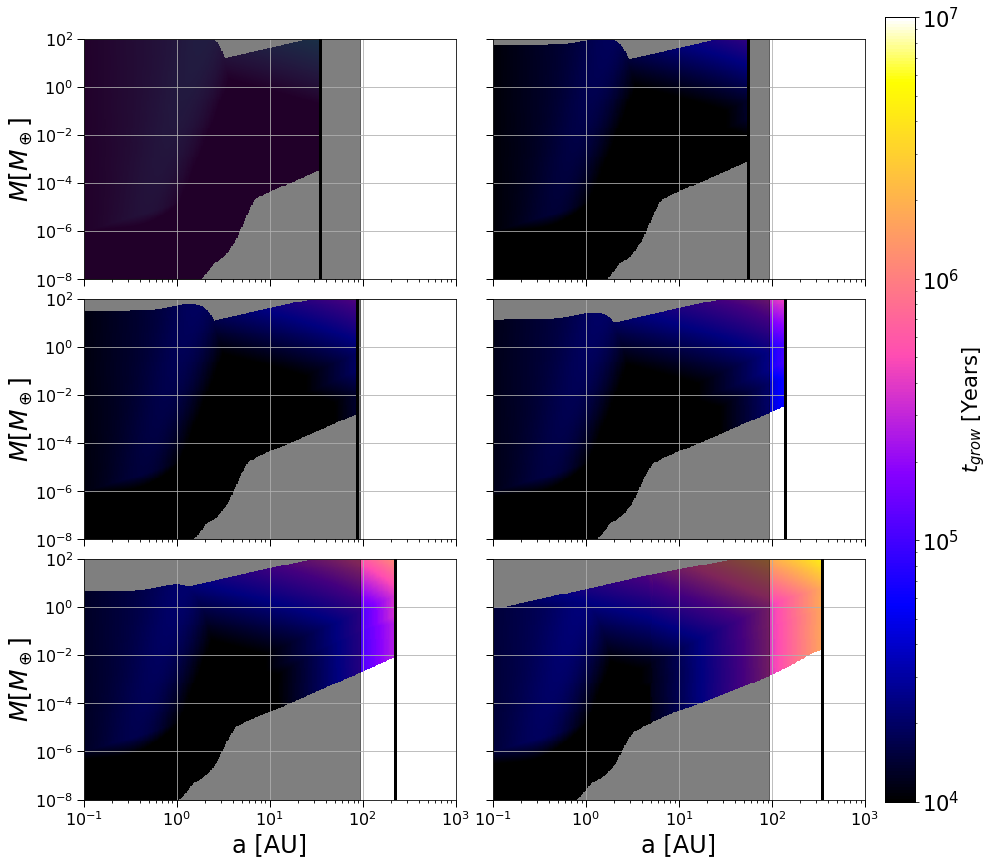

In [47]:
# Try making t_grow grid plot
from matplotlib import gridspec
import matplotlib.image as im

# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.08)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_163_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e4,vmax=1e7)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)
plt.savefig("HD_163_tgrow.pdf", bbox_inches = "tight")

## FT Tau

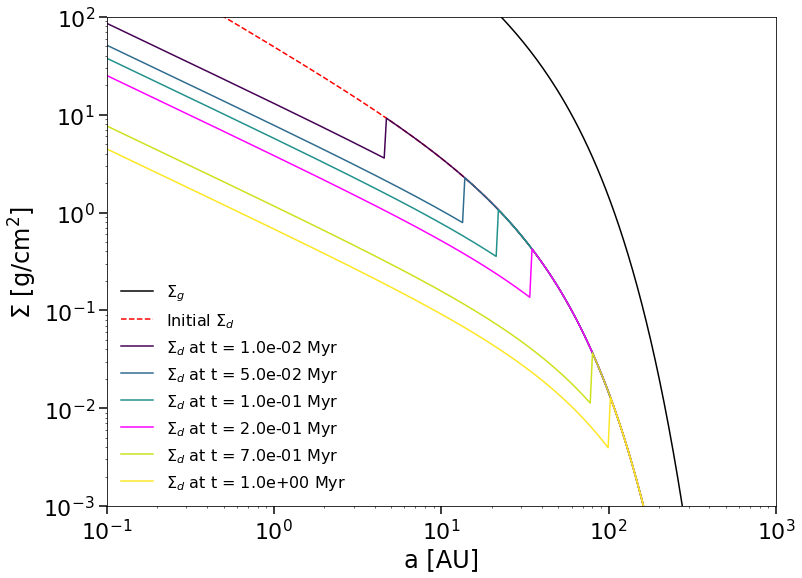

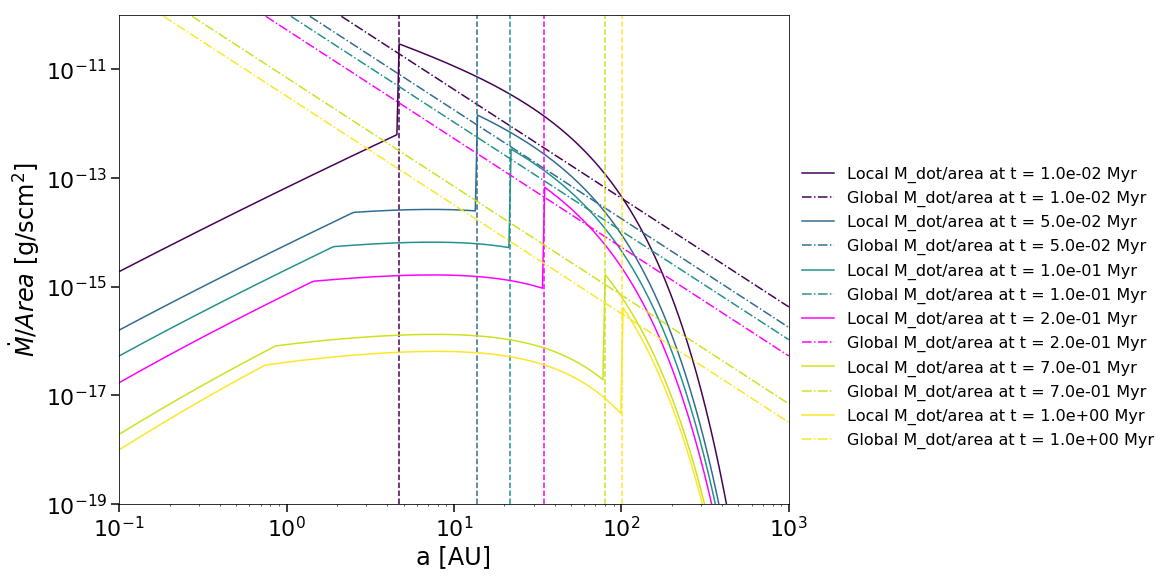

In [50]:
t_array = np.array([0.01, 0.05, 0.1, 0.2, 0.7, 1]) * 3.154e13
#t_array = np.logspace(-2,0.2, 12) * 3.154e13 # FT Tau's age is estimated at 1.6 Mya (Powell 2019 has 2 references to pull for this)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 89, 0.55, 183, 28, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas

### Creates plot of the surface densities ###
cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
line_colors[3] = 'magenta' # highlight the age of 1.6 Mya from literature in magenta

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)
    #plt.loglog(a_array, sig_d_LJ[i], label="LJ'14 surface density at t = {time} Myr".format(time=f"{t/3.154e13:.2e}"), color=line_colors[i])
    
    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[0,i], color=line_colors[i])
    #plt.loglog(a_array, sig_d_arr[1,i], color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.xlim(1e-1,1e3)
plt.ylim(1e-3,1e2)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16)
plt.savefig("FT_Tau_SD.pdf")
plt.show()



### This generates a plot to compare the M_dot per area globally (drifted) vs locally (grown) ###

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = Sig_gas[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i], linestyle='-.')
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], linestyle='--')
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.xlim(1e-1,1e3)
plt.ylim(1e-19,1e-10)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16, loc=(1.01,0.1))
plt.savefig("FT_Tau_m_dot.pdf", bbox_inches = "tight")
plt.show()

In [51]:
# Running model a bunch of times to generate color map for t_grow grid plot
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.logspace(-1,0.5, 6) * 3.154e13 #np.linspace(0.1, 3, 6) * 3.154e13
t_grow_fttau_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_Ep = sd[2]

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s_Ep[k,j])
            t_grow_fttau_arr[k,i,j] = core.t_acc

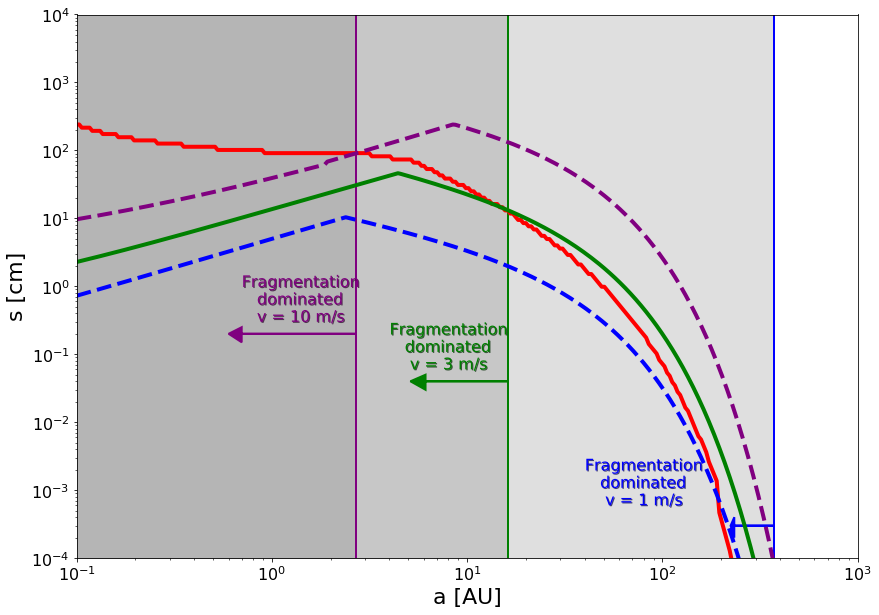

In [52]:
# Try making the max particle size plot for TW Hya, to see where the model applies
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    Sig = Sig_gas[k]
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(4e1,6e-4, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(4e0,6e-2, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(7e-1,3e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 3e-4, -140, 0, linestyle='-', linewidth=2, width=0, head_width=2e-4, head_length=10, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 4e-2, -10, 0, linestyle='-', linewidth=2, width=0, head_width=2e-2, head_length=1, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.2, -2, 0, linestyle='-', linewidth=2, width=0, head_width=0.1, head_length=.1, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e3)
plt.ylim(1e-4,1e4)
plt.savefig("FT_Tau_frag.pdf", bbox_inches = "tight")

fig = plt.figure(1,figsize=(14,10))

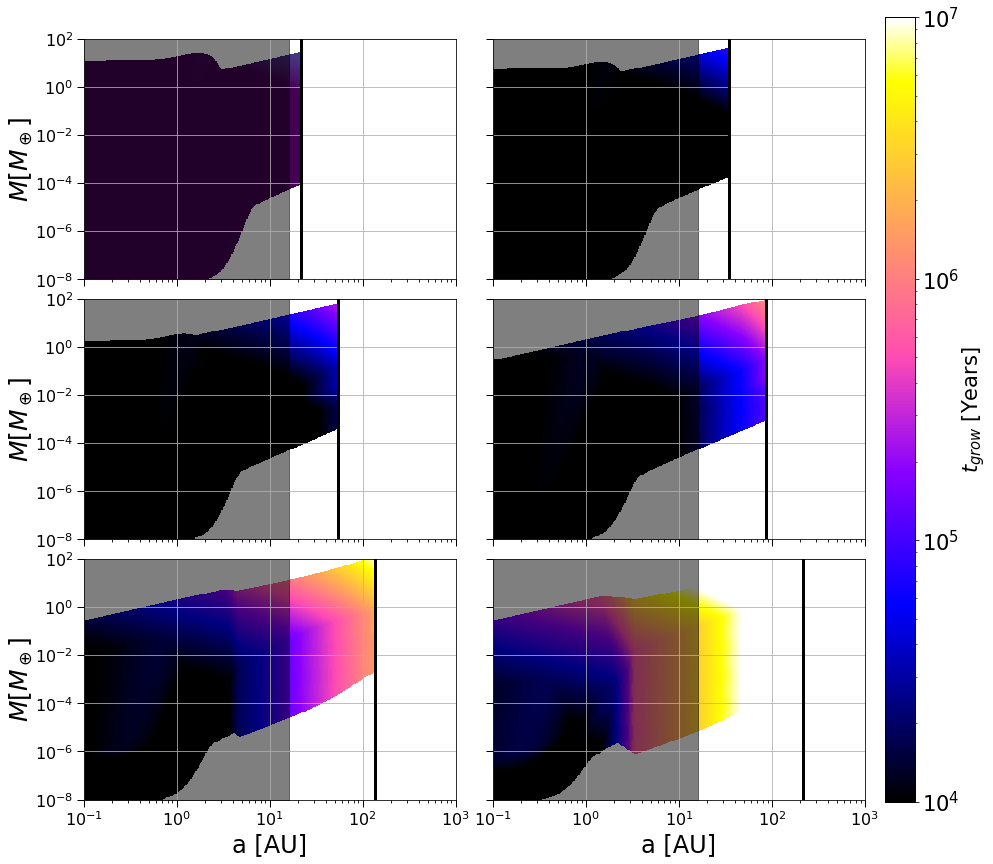

In [53]:
# Try making t_grow grid plot
# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.08)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_fttau_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e4,vmax=1e7)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)
plt.savefig("FT_Tau_tgrow.pdf", bbox_inches = "tight")

## CY Tau

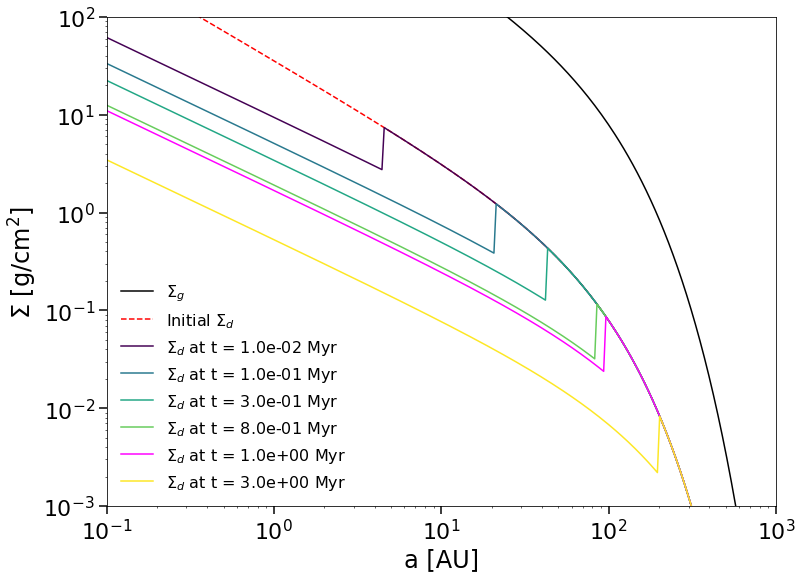

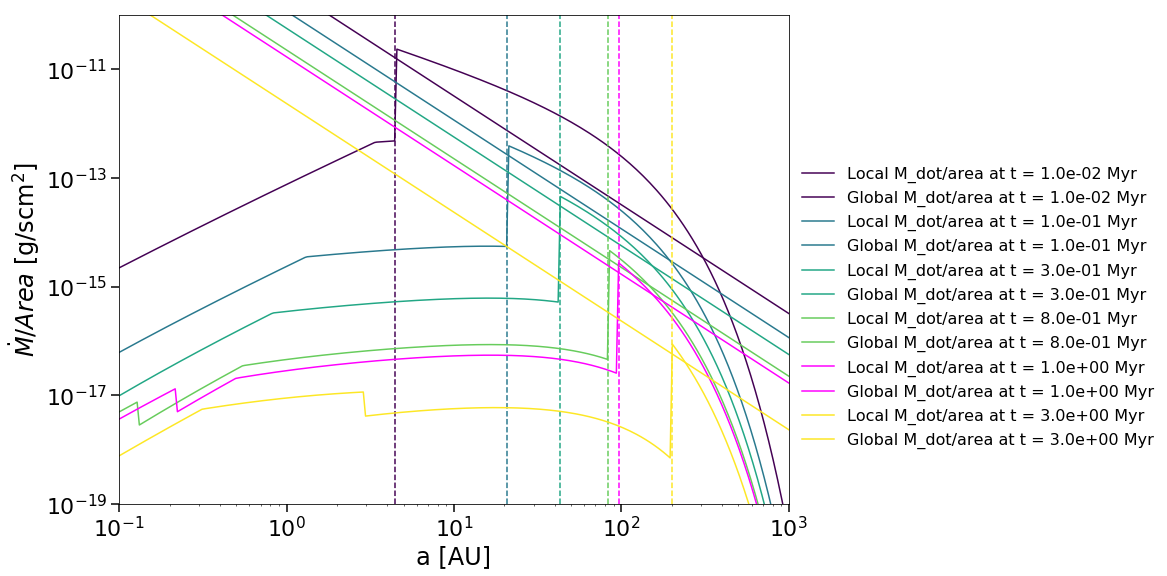

In [56]:
t_array = np.array([0.01, 0.1, 0.3, 0.8, 1, 3]) * 3.154e13
#t_array = np.logspace(-2,0, 12) * 3.154e13 # CY Tau's age is estimated at 1 Mya, from 0.8 to 3 range (Powell 2019 has 2 references to pull for this)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 98, 0.48, 55, 65.6, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb # But gamma should be just 0.28 for this fit
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas

### Creates plot of the surface densities ###
cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
line_colors[4] = 'magenta' # Highlights the estimated age in magenta

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)
    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-3,1e2)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16)
plt.savefig("CY_Tau_SD.pdf")
plt.show()



### This generates a plot to compare the M_dot per area globally (drifted) vs locally (grown) ###

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = Sig_gas[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], linestyle='--')
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-19,1e-10)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16, loc=(1.01,0.1))
plt.savefig("CY_Tau_m_dot.pdf", bbox_inches = "tight")
plt.show()

In [57]:
# Running model a bunch of times to generate color map for t_grow grid plot
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.logspace(-1,0.5, 6) * 3.154e13 #np.linspace(0.1, 3, 6) * 3.154e13
t_grow_cytau_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_Ep = sd[2]

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s_Ep[k,j])
            t_grow_cytau_arr[k,i,j] = core.t_acc

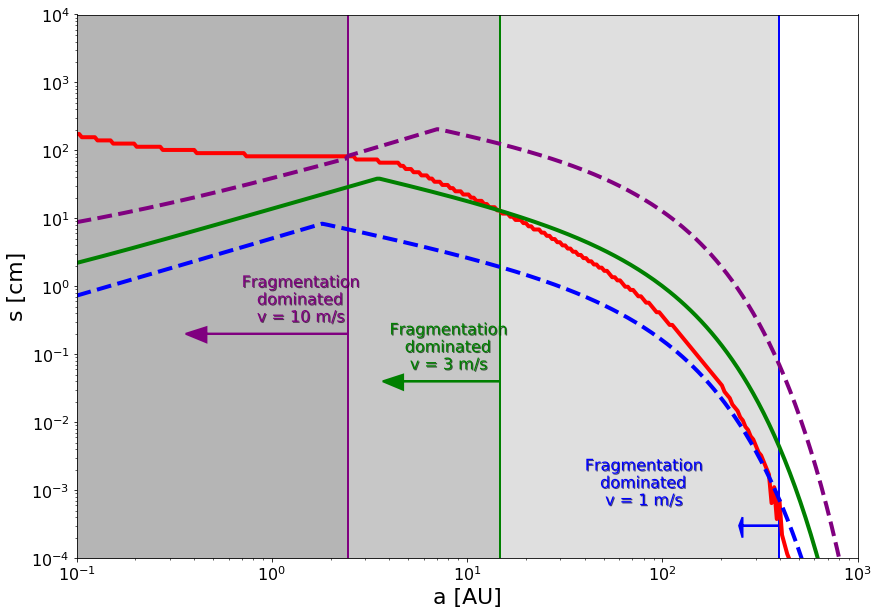

In [58]:
# Try making the max particle size plot, to see where the model applies
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    Sig = Sig_gas[k]
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(4e1,6e-4, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(4e0,6e-2, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(7e-1,3e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 3e-4, -140, 0, linestyle='-', linewidth=2, width=0, head_width=2e-4, head_length=10, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 4e-2, -10, 0, linestyle='-', linewidth=2, width=0, head_width=2e-2, head_length=1, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.2, -2, 0, linestyle='-', linewidth=2, width=0, head_width=0.1, head_length=.1, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e3)
plt.ylim(1e-4,1e4)
plt.savefig("CY_Tau_frag.pdf", bbox_inches = "tight")

fig = plt.figure(1,figsize=(14,10))

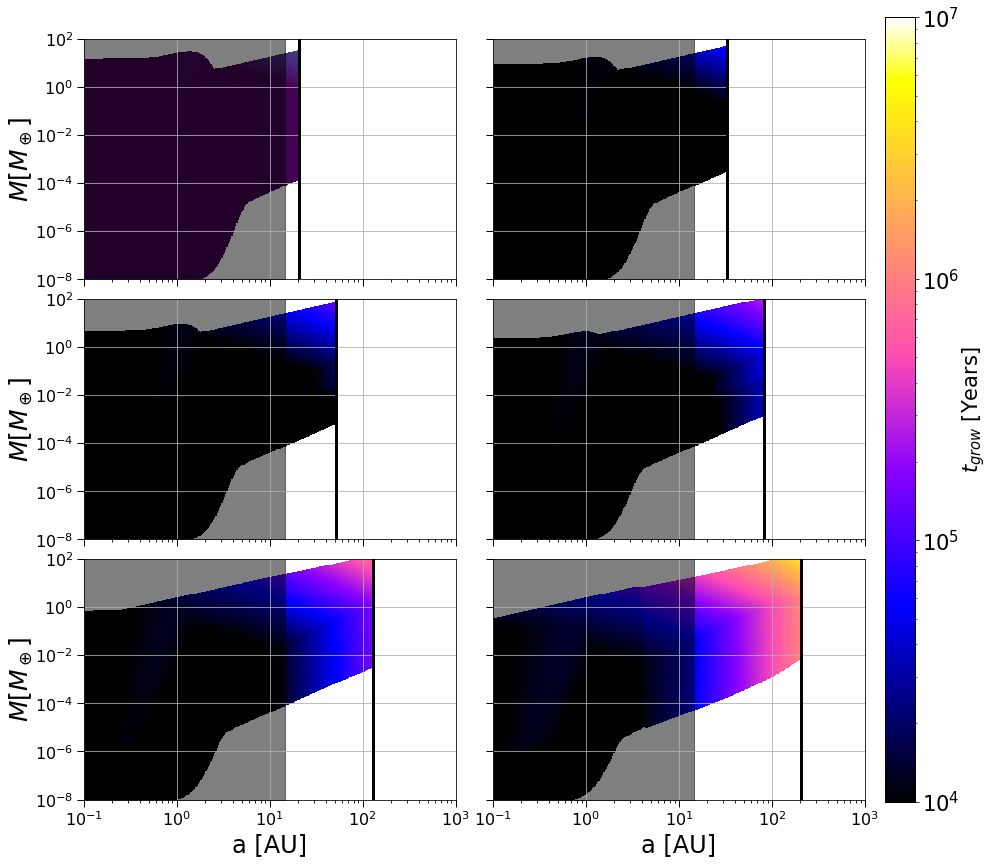

In [59]:
# Try making t_grow grid plot
# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.08)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_cytau_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e4,vmax=1e7)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)
plt.savefig("CY_Tau_tgrow.pdf", bbox_inches = "tight")

## DoAr 25

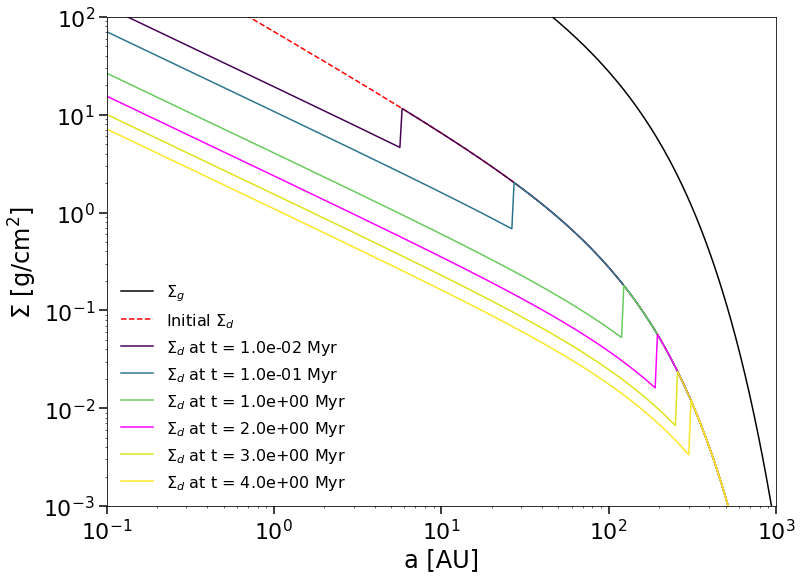

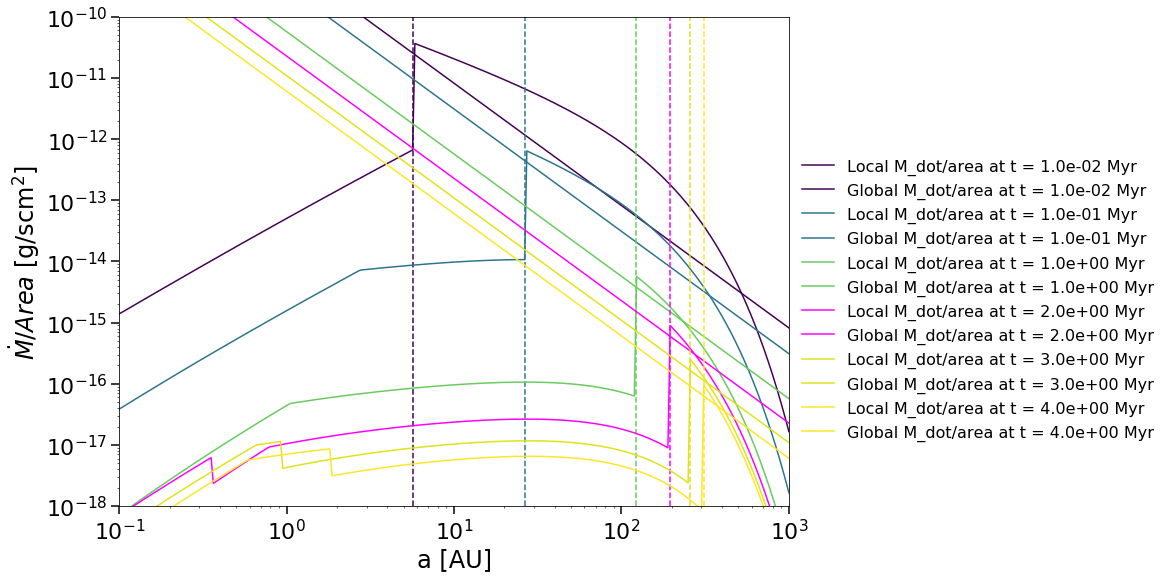

In [60]:
t_array = np.array([0.01, 0.1, 1, 2, 3, 4]) * 3.154e13
#t_array = np.logspace(-2,0.3, 12) * 3.154e13 # DoAr 25's age is estimated at 2 Myr, but as high as 4 (Powell 2019 has 2 references to pull for this)
a_array = np.logspace(-1, 3, 300)

eps_p = 0.5
eps_d = 0.5/10 #Growth efficiency, eps_d = eps_g,d/xi from eqn ~9 of LJ14
delt = 3/7 # Constant on drift velocity
Lamb = 47/14 # Constant on t_grow = Lamb * t_drift
f_d = 1e-2 # Initial dust to gas ratio
    
params = 123, 1, 68, 105, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb # But gamma is just 0.36
T_0, m_star, sigma_0, r_crit, rho_int, alpha, f_d, eps_p, eps_d, delt, Lamb = params

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
sig_d_LJ = np.zeros(sd[1].shape)

# Now, extract just the dust-to-gas, and the Sig_p arrays
sig_d_arr = np.zeros([2, t_array.size, a_array.size])
for i, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_arr[0,i] = sig_p(f_d, a_PF, a_array, t, params)
    sig_d_arr[1,i] = dust_to_gas(t, a_PF, a_array, params) * Sig_gas

### Creates plot of the surface densities ###
cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]
line_colors[3] = 'magenta' # Hightlights the estimated age in magenta

fig = plt.figure(1,figsize=(12,9))
plt.loglog(a_array, Sig_gas, 'k-', label="$\Sigma_g$")
plt.loglog(a_array, 1e-2*Sig_gas, 'r--', label="Initial $\Sigma_d$")
for i,t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    sig_d_LJ[i] = LJ_sig_p(1e-2, a_PF, a_array, t, params)
    plt.loglog(a_array, sig_d_array[i], label='$\Sigma_d$ at t = {time} Myr'.format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    
plt.ylabel('$\Sigma$ $[\mathrm{g}/\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-3,1e2)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16)
plt.savefig("DoAr_25_SD.pdf")
plt.show()



### This generates a plot to compare the M_dot per area globally (drifted) vs locally (grown) ###

a_PF_arr = np.zeros(t_array.size)
M_dot_spec = np.zeros([2, t_array.size, a_array.size])
for i,t in enumerate(t_array):
    Sigma_d = sig_d_array[i]
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_arr[i] = a_PF
    i_PF = np.argmin(abs(a_array - a_PF))
    Sig_PF = Sig_gas[i_PF]
    M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * f_d*Sig_PF
    
    M_dot_loc_specific = dust_to_gas(t, a_PF, a_array, params)*Sig_gas/t
    M_dot_glo_specific = M_dot/(2*np.pi * (a_array*fn.au)**2)
    
    M_dot_spec[0,i] = M_dot_loc_specific
    M_dot_spec[1,i] = M_dot_glo_specific

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.loglog(a_array, M_dot_spec[0,i], label="Local M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.loglog(a_array, M_dot_spec[1,i], label="Global M_dot/area at t = {time} Myr".format(time=f"{t/3.154e13:.1e}"), color=line_colors[i])
    plt.axvline(x=a_PF_arr[i], color=line_colors[i], linestyle='--')
plt.ylabel('$\dot{M}/Area$ $[\mathrm{g}/\mathrm{s}\mathrm{cm}^{2}]$', fontsize=24)
plt.xlabel('a [AU]', fontsize=24)
plt.ylim(1e-18,1e-10)
plt.xlim(1e-1,1e3)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16, loc=(1.01,0.12))
plt.savefig("DoAr_25_m_dot.pdf", bbox_inches = "tight")
plt.show()

In [61]:
# Running model a bunch of times to generate color map for t_grow grid plot
## Try to make color map, with x-axis showing a (AU), y-axis showing M_core (M_earth), and color showing t_acc
m_core_arr = np.logspace(-10, 2, 300)
t_array = np.logspace(-1,0.5, 6) * 3.154e13 #np.linspace(0.1, 3, 6) * 3.154e13
t_grow_doar25_arr = np.zeros([len(t_array), len(m_core_arr), len(a_array)])

sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
s_Ep = sd[2]

for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    for i, m_c in enumerate(m_core_arr):
        for j, a_au in enumerate(a_array):
            sig_gas = Sig_gas[j]
            sig_d = sig_d_array[k,j]
            temp = T_0*a_au**(-3./7.)
            core = Core(a_core_au=a_au, m_core_earthmasses=m_c, alpha=alpha, m_star_solarmasses=m_star,
                    temp_in=temp, sig_p_in=sig_d, sig_g_in=sig_gas)
            core.main(s_Ep[k,j])
            t_grow_doar25_arr[k,i,j] = core.t_acc

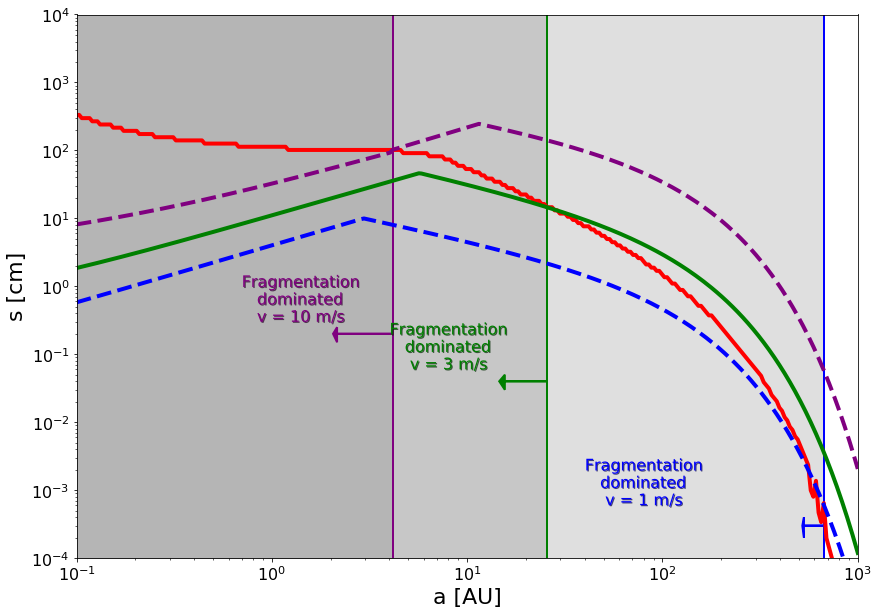

In [62]:
# Try making the max particle size plot for TW Hya, to see where the model applies
v_frag = np.array([1,3,10]) *1e2 #1, 3 and 10 m/s
f_f = 0.5 

s_array = np.logspace(-6,8,300)
t_g_array = np.zeros(s_array.shape)
t_d_array = np.zeros(s_array.shape)
s_grow = np.zeros(a_array.shape)
s_frag = np.zeros([v_frag.size, a_array.size])
frag_loc = np.zeros(v_frag.size)
for k, a in enumerate(a_array):
    T = T_0 * (a**(-3/7))
    mstar = m_star * fn.m_sun
    Sig = Sig_gas[k]
    c_s = np.sqrt((boltzmann*T)/(2.35*mH))
    Om = np.sqrt((G*mstar)/(a*fn.au)**3.)
    v_kep = Om * (a*fn.au)
    eta = (c_s)**2/(2*(v_kep)**2)
    
    for i, s in enumerate(s_array):
        St = st_rad(rad=s,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
        t_g_array[i] = t_grow(s, a, f_d, params)
        t_d_array[i] = (a*fn.au)/(2 * St * c_s**2/(2*v_kep))
        
    s_grow[k] = s_array[np.argmin(abs(t_g_array - t_d_array))]
    st_frag = v_frag**2/(3 * alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        s_frag[j,k] = st_solver(st=st_frag[j], alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig) #f_f * (2 * Sig * v_frag**2)/(3 * np.pi * rho_int * alpha * c_s**2)
    v_rel = np.sqrt(alpha * c_s**2)
    for j,v_f in enumerate(v_frag):
        delta = 1
        s_old = 0
        while delta > 0.01:
            st_frag = v_f**2/(3 * v_rel**2)
            s_frag[j,k] = st_solver(st=st_frag, alph=alpha, a_au=a, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
            v_rel = np.sqrt(alpha * c_s**2 * (1 + d_V_12(t_1=st_frag,t_2=0.5*st_frag)))
            delta = (s_frag[j,k] - s_old)/s_frag[j,k]
            s_old = s_frag[j,k]

for j,v_f in enumerate(v_frag):
    frag_loc[j] = a_array[np.argmin(abs(s_frag[j] - s_grow)/s_grow)]

axis_font = {'size':'22'} # Sets font size
tick_font = {'size':'16'}
fig = plt.figure(1,figsize=(14,10))
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[0], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[1], alpha=0.25, color='grey')
plt.fill_betweenx(np.logspace(-4,4,100), 1e-1, frag_loc[2], alpha=0.25, color='grey')
plt.text(4e1,6e-4, 'Fragmentation\n   dominated\n    v = 1 m/s', color='blue', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(4e0,6e-2, 'Fragmentation\n   dominated\n    v = 3 m/s', color='green', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.text(7e-1,3e-1, 'Fragmentation\n   dominated\n   v = 10 m/s', color='purple', **tick_font,
                path_effects=[path_effects.withSimplePatchShadow(offset=(1, -1), alpha=0.7)])
plt.axvline(x=frag_loc[0], color='blue', linestyle='-', linewidth=2)
plt.arrow(frag_loc[0], 3e-4, -140, 0, linestyle='-', linewidth=2, width=0, head_width=2e-4, head_length=10, fc='blue', ec='blue')
plt.axvline(x=frag_loc[1], color='green', linestyle='-', linewidth=2)
plt.arrow(frag_loc[1], 4e-2, -10, 0, linestyle='-', linewidth=2, width=0, head_width=2e-2, head_length=1, fc='green', ec='green')
plt.axvline(x=frag_loc[2], color='purple', linestyle='-', linewidth=2)
plt.arrow(frag_loc[2], 0.2, -2, 0, linestyle='-', linewidth=2, width=0, head_width=0.1, head_length=.1, fc='purple', ec='purple')
plt.loglog(a_array, s_grow, 'r-', linewidth=4, label='Drift limited particle size')
plt.loglog(a_array, s_frag[1], 'g-', linewidth=4, label='Fragmentation limited particle size, v = 3 m/s')
plt.loglog(a_array, s_frag[0], 'b--', linewidth=4, label='Fragmentation limited particle size, v = 1 m/s')
plt.loglog(a_array, s_frag[2], '--', color='purple', linewidth=4, label='Fragmentation limited particle size, v = 10 m/s')
plt.ylabel('s [cm]', **axis_font)
plt.xlabel('a [AU]', **axis_font)
plt.xticks(**tick_font)
plt.yticks(**tick_font)
plt.xlim(1e-1,1e3)
plt.ylim(1e-4,1e4)
plt.savefig("DoAr25_frag.pdf", bbox_inches = "tight")

fig = plt.figure(1,figsize=(14,10))

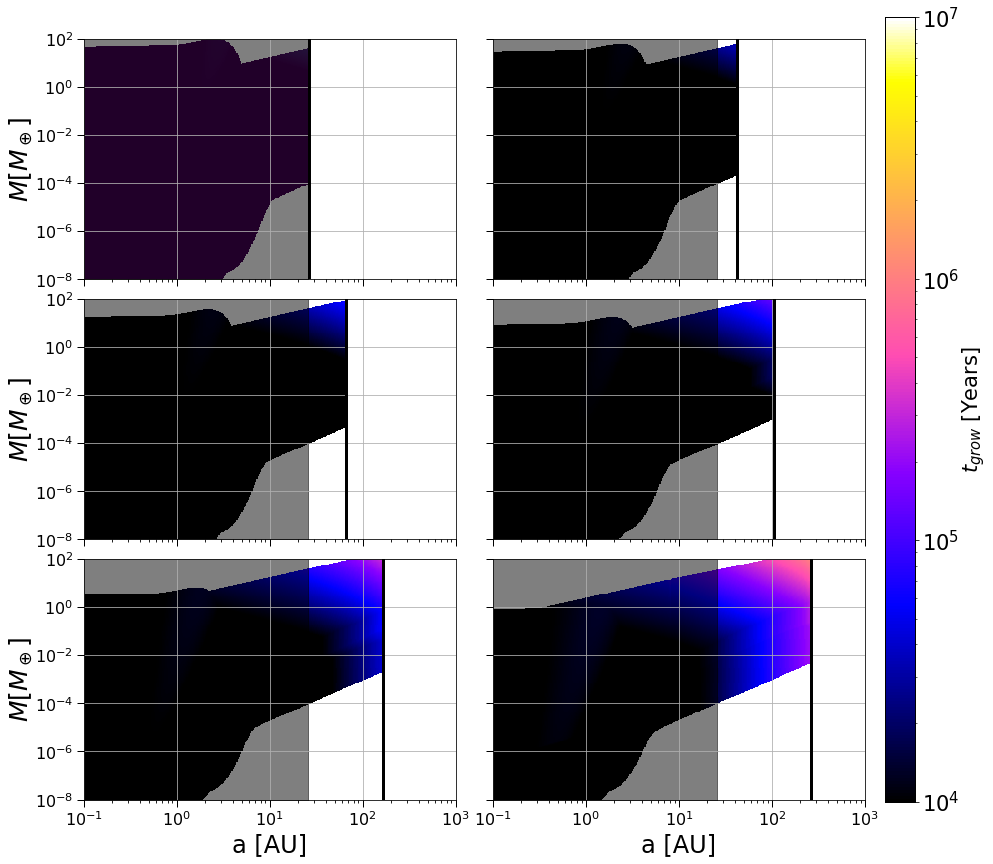

In [63]:
# Setup figure and grid
fig = plt.figure(figsize=(14,14))
gs = gridspec.GridSpec(3, 2)
gs.update(wspace=0.1, hspace=0.08)
axis_font = {'size':'36'} # Sets font size
tick_font = {'size':'32'}

ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 0])
ax3 = plt.subplot(gs[1, 1])
ax4 = plt.subplot(gs[2, 0])
ax5 = plt.subplot(gs[2, 1])

X, Y = np.meshgrid(a_array, m_core_arr)
for i,t in enumerate(t_array):
    if i == 0:
        ax = ax0
    if i == 1:
        ax = ax1
    if i == 2:
        ax = ax2
    if i == 3:
        ax = ax3
    if i == 4:
        ax = ax4
    if i == 5:
        ax = ax5
    im = ax.pcolormesh(X,Y,t_grow_doar25_arr[i], cmap=cmap,norm=LogNorm(),vmin=1e4,vmax=1e7)
    ax.grid()
    cmap = 'gnuplot2'
    im.set_edgecolor('face')
    ax.tick_params(which='major', length=7,width=1.0)
    ax.tick_params(which='minor', length=3.0,width=0.85)
    if i == 4 or i == 5:
        ax.set_xlabel('a [AU]',fontsize=24)
        #ax.fill_betweenx(m_core_arr, 1e-1, a_interior[i], alpha=0.5, color='black')
    else:
        ax.tick_params(labelbottom=False)
    ax.fill_betweenx(m_core_arr, 1e-1, frag_loc[1], alpha=0.5, color='black')
    if i == 0 or i == 2 or i == 4:
        ax.set_ylabel(r'$M \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
    else:
        ax.tick_params(labelleft=False) 
    ax.set_ylim(1e-8,1e2)
    ax.set_xlim(1e-1, 1e3)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(labelsize=16)
    
    ax.axvline(x=(3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au, linewidth=3, color='k')
    cax = fig.add_axes([0.92, 0.123, 0.03, 0.778])
    cb = fig.colorbar(im, cax=cax, cmap=cmap, norm=LogNorm())
    cb.set_label(label=r'$t_{grow}$ [Years]',fontsize=21,labelpad=0.1)
    cb.ax.tick_params(labelsize=21)
plt.savefig("DoAr25_tgrow.pdf", bbox_inches = "tight")

## Stop here, unless you want to explore the numerical calculation of the pebble front

In [3]:
def a_PF_numeric(a_arr, t_disk, params):
    """Numerically calculates the pebble front location, in order to compare to the analytic form presented in 
    Lambrechts and Johansen 2014."""
    T_0, m_star, sigma_0, r_crit, rho_int, alpha = params
    eps_g = 0.5
    T = T_0*a_arr**(-3./7.)
    c_s = fn.sound_speed(T)
    v_kep = fn.vkep(m_star*fn.m_sun, a_arr*fn.au)
    Om = v_k/(a_arr*fn.au)
    eta = fn.eta(c_s, v_k)
    
    sd = surface_density(a_array, t_disk, params)
    a_transition = (np.pi/8)**(3/4) * (alpha * np.sqrt(Sig_g) * M_dot)/(9 * np.pi**2 * eps_p**2 * v_kep * (lambda_mfp * rho_int * eta * alpha)**(3/2))
    # Is it tubulent?
    Tubulent = False
    for i,a in enumerate(a_arr):
        if alpha*c_s[i]**2 > (eta[i]*v_kep[i])**2:
            Turbulent = True
    
    # M_dot depends on the pebble front location
    #i_PF = np.argmin(abs(a - a_PF))
    #Sig_p0_PF = f_d*Sig_g[i_PF]
    #M_dot = (4*np.pi)/(3) * (a_PF*fn.au)**2/t * Sig_p0_PF
    lambda_mfp = fn.mean_free_path(fn.mu, Sig_g/(2*c_s/om), fn.cross)
    Re = (eta**2 * v_kep**2 + alpha * c_s**2)/(lambda_mfp * np.sqrt(8/np.pi) * c_s * om)
    # Check if t_disk is an array or not
    if np.isscalar(t_disk):
        if Turbulent:
            s_max_St = 3/32 * (8/np.pi)**(1/8) * 2**(3/4)/np.sqrt(np.pi) * Re**(1/8)/(rho_int * eta) * (rho_int * Sig * lambda_mfp)**(1/4)/np.sqrt(a_arr * v_kep * eps_g)
            s_max_Ep = 9/256 * np.sqrt(np.pi/2) * (np.pi/8)**(1/4) * (sd[1]**2 * v_kep**4 * eps_g**2)/(rho_int * Sig * c_s**4) * np.sqrt(alpha * c_s/(lambda_mfp * Om))
        else:
            s_max_St = 3/(4 * 8**(3/8) * np.pi**(5/8)) * np.sqrt(M_dot * eps_g/(a_arr * v_kep * alpha)) * (Sig * lambda_mfp)**(1/4)/(eta * rho_int)**(3/4)
            s_max_Ep = (9 * np.sqrt(np.pi/2))/128 * (sd[1]**2 * eps_g**2)/(alpha * rho_int * eta * Sig)
    else:
        for i,t in enumerate(t_disk):
            if Turbulent:
                s_max_St = 3/32 * (8/np.pi)**(1/8) * 2**(3/4)/np.sqrt(np.pi) * Re**(1/8)/(rho_int * eta) * (rho_int * Sig * lambda_mfp)**(1/4)/np.sqrt(a_arr * v_kep * eps_g)
                s_max_Ep = 9/256 * np.sqrt(np.pi/2) * (np.pi/8)**(1/4) * (sd[1,i]**2 * v_kep**4 * eps_g**2)/(rho_int * Sig * c_s**4) * np.sqrt(alpha * c_s/(lambda_mfp * Om))
            else:
                s_max_St = 3/(4 * 8**(3/8) * np.pi**(5/8)) * np.sqrt(M_dot * eps_g/(a_arr * v_kep * alpha)) * (Sig * lambda_mfp)**(1/4)/(eta * rho_int)**(3/4)
                s_max_Ep = (9 * np.sqrt(np.pi/2))/128 * (sd[1,i]**2 * eps_g**2)/(alpha * rho_int * eta * Sig)
    t_grow_arr = np.zeros(a_arr.size)
    for i,a in enumerate(a_arr):
        if a * fn.au < a_transition:
            t_grow_arr[i] = t_grow(s_max_St[i], a, 1e-2, params)
        else:
            t_grow_arr[i] = t_grow(s_max_Ep[i], a, 1e-2, params)
    
    if np.isscalar(t_disk):
        # Finds the location where t_disk = 10* t_grow
        a_PF = a_arr[np.argmin(abs(10*t_grow_arr - t_disk))]
    else:
        a_PF = np.zeros(t_disk.size)
        for i,t in enumerate(t_disk):
            a_PF[i] = a_arr[np.argmin(abs(10*t_grow_arr - t))]
    return a_PF

# Let's try numerically calculating a_PF
t_array = np.linspace(0.1,3, 30) * 3.154e13 #np.logspace(-1,0.5, 6) * 3.154e13
a_array = np.logspace(0, 3, 300)
sig_d_array = np.zeros([t_array.size, a_array.size])
params = [200, 1, 375, 30, 1.6, 1e-3]
T_0, m_star, sigma_0, r_crit, rho_int, alpha = params
eps_g = 0.5
eps_d = eps_g/10
f_d = 1e-2
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
a_PF_arr = np.zeros(t_array.size)

for k, t in enumerate(t_array):
    a_temp_arr = np.zeros(a_array.size)
    for j, a_au in enumerate(a_array):
        sig_gas = Sig_gas[j]
        sig_d = sig_d_array[k,j]
        temp = T_0*a_au**(-3./7.)
        c_s = fn.sound_speed(temp)
        v_th = np.sqrt(8/np.pi)*c_s
        v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
        Om = v_k/(a_au*fn.au)
        rho_gas = sig_gas * Om/c_s
        eta = fn.eta(c_s, v_k)
        v_0 = eta * v_k
        v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
    
        s = np.sqrt(3)/8 * sig_d/(eta*rho_int)
        St = st_rad(rad=s,alph=alpha,a_au=a_au,m_suns=m_star,m_earths=1,sig_in=sig_gas,temp_in=temp)
        t_s = St/Om
        a_PF = np.sqrt((t_s * c_s**2 * t)/10)/fn.au
        a_temp_arr[j] = a_PF

    a_PF_arr[k] = a_array[np.argmax(abs(a_temp_arr[1:] - a_temp_arr[:-1]))]

cmap = cm.viridis
vmax = max(t_array)
vmin = min(t_array)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=vmin,vmax=vmax))
sm.set_array([])
line_colors = [sm.to_rgba(t) for t in t_array]    
    
print(a_PF_arr)
print((3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au)

[ 25.98458105  41.24626383  54.42343548  65.47168402  76.96399902
  86.38828443  94.75205303 103.92556829 113.98722666 122.1677349
 127.94502732 137.12724344 143.6119686  150.40335536 157.51590571
 164.96480741 172.76596647 180.93604107 185.16484179 193.92125721
 198.45354578 203.09176209 212.69593867 217.66702532 222.7542952
 227.96046373 233.28830979 238.74067719 244.32047622 250.03068519]
[ 26.4411187   41.97265965  54.99974328  66.62744408  77.31430011
  87.30665034  96.75613665 105.76447482 114.40407627 122.72880132
 130.78008521 138.59066859 146.18699114 153.59079311 160.82022495
 167.89063858 174.81516595 181.60515102 188.27047855 194.81982833
 201.26087463 207.60044483 213.84464692 219.99897312 226.06838494
 232.05738351 237.97006834 243.81018655 249.5811747  255.28619426]


In [321]:
# MMSN params
params = np.loadtxt("mmsn_params.txt")
print(params)
# M_star, T_0, Sig_0, R_crit, alpha, t_disk

[1.0000e+00 1.5000e+02 3.4300e+02 1.0000e+01 4.0000e-04 3.1536e+13]


In [223]:
# This cell calculates the location of the pebble front as it bounces back from the disk edge
params = [121, 1, 400, 20, 1.6, 1e-5]
T_0, m_star, sigma_0, r_crit, rho_int, alpha = params
t_disk = 3.1536e13 # 1 Myr
    
a_array = np.logspace(-1, 2, 300)
gamma = 1
sigma_g = sig_g(a_array, sigma_0, params)
f_d = 1e-2
t_array = np.logspace(-1,0.5, 8) * 3.154e13

#a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au
a_PF = ((9 * np.pi * eps_d * eps_g * t_disk)/(128 * 10**4 * alpha))**(2/3) * (fn.G * m_star * fn.m_sun)**(1/3) / fn.au
t_trans = t_transition(a_array, t_array, a_PF, params)
a_edge = 100
t_edge = (16/3)**(1/2) * (eps_d * f_d)**(-1) * (fn.G * m_star * fn.m_sun)**(-1/2) * (a_edge * fn.au)**(3/2)
a_drifted = 0
a_interior = np.zeros(t_array.size)
sigma_d = np.zeros([t_array.size, a_array.size])
for i,t in enumerate(t_array):
    if t > t_trans: #if a_PF[i] > a_edge:
        # If in Powell et al. 2017 regime, find drift time for maximally size particle
        if a_interior[i-1] != 0:
            a = a_interior[i-1]
        else: a = a_edge

        j = np.argmin(abs(a - a_array))
        gamma = 1.0
        Sig = sig_g(a, sigma_0, params) #sigma_0 * ((a/r_crit)**(-gamma))*np.exp(-(a/r_crit)**(2-gamma))
        T = T_0 * (a**(-3/7))
        c_s = np.sqrt((boltzmann*T)/(2.35*mH))
        Om = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au)**3)
        v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a * fn.au))
        eta = (c_s)**2/(2*(v_kep)**2)
        v0 = eta * v_kep
        St = np.sqrt(3)/8 * eps_p/eta * sig_p(f_d, a_PF[i], a_array, t, params)/Sig # Max particle size for all a, at t=t_edge
        v_drift = - 2 * v0 * (St[j]/(1 + St[j]**2))
        if i != 0:
            t_old = max(t_edge, t_array[i-1])
            t_diff = t - t_old
        else: t_diff = 0

        j = np.argmin(abs(a_edge - a_array))
        st_edge = St[j] # The maximum St at the edge of the disk, when the pebble front hits the disk edge
        s_edge = st_solver(st=st_edge, alph=alpha, a_au=a_edge, m_suns=m_star, m_earths=1, temp_in=T, sig_in=Sig)
        t_diff_arr = np.linspace(t_old, t_diff, 1000)
        a_diff_arr = np.zeros(t_diff_arr.size)
        for k, t_d in enumerate(t_diff_arr):
            if k == 0:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            elif a_drifted < a:
                T = T_0 * (a_new**(-3/7))
                c_s = np.sqrt((boltzmann*T)/(2.35*mH))
                Om = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au)**3)
                v_kep = np.sqrt(fn.G * m_star*fn.m_sun/(a_new * fn.au))
                eta = (c_s)**2/(2*(v_kep)**2) #0.0015 * a_new**(1/2)t
                v0 = eta * v_kep
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=a_new,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            else:
                st_diff = st_rad(rad=s_edge,alph=alpha,a_au=0.0001,m_suns=m_star,m_earths=1,sig_in=Sig,temp_in=T)
            v_drift = - 2 * v0 * (st_diff/(1 + st_diff**2))
            if k == 0:
                a_diff_arr[0] = v_drift * (t_diff_arr[1] - t_d) / fn.au
                a_drifted = abs(a_diff_arr[0])
                a_new = a - a_drifted
            elif a_drifted < a:
                a_diff_arr[k] = v_drift * (t_d - t_diff_arr[k-1]) / fn.au
                a_drifted = a_drifted + abs(a_diff_arr[k])
                a_new = a - a_drifted
            else:
                a_new = 0.0001
        # Finds the locations to which maximally sized particles have drifted by new disk time
        a_interior[i] = a_new #a - abs(v_drift * t_diff)/fn.au

print(a_interior)

NameError: name 't_transition' is not defined

In [ ]:
## Plotting m_dot comparison
t_array = np.linspace(0.1, 1, 10) * 3.154e13 #np.logspace(-1,0.5, 16) * 3.154e13
line_colors = [sm.to_rgba(t) for t in t_array]
a_array = np.logspace(0, 3, 300)
M_dot_arr = np.zeros([a_array.size, t_array.size, 2])
sig_d_array = np.zeros([t_array.size, a_array.size])
#params = [T_0, m_star, sig_0, r_crit, rho_int, alpha, a_edge]
params = 200, 1, 375, 20, 1.6, 1e-4
eps_g = 0.5
eps_d = 0.5/10
sd = surface_density(a_array, t_array, params)
Sig_gas = sd[0]
sig_d_array = sd[1]
a_PF_arr = np.zeros(t_array.size)

T_0, m_star, sigma_0, r_crit, rho_int, alpha = params
temp_arr = np.zeros([t_array.size, a_array.size])
for k, t in enumerate(t_array):
    a_PF = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t**(2/3) / fn.au
    a_PF_ind = np.argmin(abs(a_array - a_PF))
    a_PF_arr[k] = a_PF
    for j, a_au in enumerate(a_array):
        sig_gas = Sig_gas[j]
        sig_d = sig_d_array[k,j]
        sig_gas_PF = Sig_gas[a_PF_ind]
        temp = T_0*a_au**(-3./7.)
        temp_arr[k,j] = temp
        c_s = fn.sound_speed(temp)
        v_th = np.sqrt(8/np.pi)*c_s
        v_k = fn.vkep(m_star*fn.m_sun, a_au*fn.au)
        Om = v_k/(a_au*fn.au)
        rho_gas = sig_gas * Om/(2*c_s)
        eta = fn.eta(c_s, v_k)
        v_0 = eta * v_k
        v_g = np.sqrt(v_0**2 + (np.sqrt(alpha) * c_s)**2)
        lambda_mfp = fn.mean_free_path(fn.mu,rho_gas,fn.cross)
        nu = lambda_mfp*np.sqrt(8/np.pi)*c_s
        Re = (v_g**2)/(nu*Om) #(alpha*c_s**2)/(nu*Om)
        #print("Reynolds number is ", Re)

        if a_PF > a_edge:
            St = (a_au*fn.au)/(2 * v_g * t)
            s = st_solver(st=St, alph=alpha, a_au=a_au, m_suns=m_star, m_earths=1, temp_in=temp, sig_in=sig_gas)
        else:
            #s = 3*np.sqrt(2)/16 * sig_d/(eta*rho_int)
            #St = 3*np.sqrt(np.pi)/16 * sig_d/(eta * sig_gas) #Om*fn.ts_eps(rho_int, rho_gas, s, v_th) #st_rad(rad=s,alph=alpha,a_au=a_au,m_suns=m_star,m_earths=1,sig_in=sig_gas,temp_in=temp)
            # Assuming laminar velocity is the relative velocity
            s = (9 * np.sqrt(np.pi/2))/128 * (sig_d**2 * eps_g**2)/(alpha * rho_int * eta * sig_gas)
            St = (9 * np.pi)/(256) * (sig_d**2 * eps_g**2)/(alpha * eta * sig_gas**2)
            # Assuming turbulent velocity instead
            #s = (9 * np.sqrt(np.pi))/512 * (np.pi/8)**(1/4) * np.sqrt(fn.cross/fn.mu) * (sig_d**2 * np.sqrt(alpha)  * v_kep**4)/(c_s**4 * rho_int * np.sqrt(sig_gas))
            #St = (9 * np.pi)/(512 * np.sqrt(2)) * (np.pi/8)**(1/4) * np.sqrt(fn.cross/fn.mu) * (sig_d**2 * np.sqrt(alpha)  * v_kep**4)/(c_s**4 * sig_gas**(3/2))
        
        m = 4/3 * np.pi * s**3 * rho_int
        m_dot_global = 4 * np.pi/3 * ((a_PF*fn.au)**2 / t) * f_d * sig_gas_PF / (a_au*fn.au)**2
        #m_dot_local = sig_d * (Om/(2*c_s)) * np.sqrt(St/alpha) * np.pi * s**2 * (c_s * np.sqrt(2 * St * alpha)) * sig_d/m
        m_dot_local = sig_d * (Om/(2*c_s)) * np.sqrt(St/alpha) * np.pi * s**2 * (2 * eta * v_kep * St) * sig_d/m # Assume laminar velocity
        #m_dot_local = np.sqrt(a_PF)/200 * sig_d * (Om/(2*c_s)) * np.sqrt(St/alpha) * np.pi * s**2 * (St/2 * np.sqrt(alpha) * c_s * (alpha * c_s/(fn.mean_free_path(fn.mu,sig_gas,fn.cross) * v_th * Om))**(1/4)) * sig_d/m # Assume turbulent velocity
        M_dot_arr[j,k,0] = m_dot_global
        M_dot_arr[j,k,1] = m_dot_local

fig = plt.figure(1,figsize=(12,9))
for i,t in enumerate(t_array):
    plt.vlines(a_PF_arr[i], 10**-20, 1, color=line_colors[i], linewidth=2, linestyle='-.')
    plt.loglog(a_array, M_dot_arr[:,i,0], label='t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i], linestyle='--')
    plt.loglog(a_array, M_dot_arr[:,i,1], label='t = {time} Myr'.format(time=f"{t/3.154e13:.2n}"), linewidth=3, color=line_colors[i], linestyle='-')
plt.ylabel('$\dot{M}$')#, **axis_font)
plt.xlabel('a [AU]')#, **axis_font)
plt.xlim(1e0, 2e2)
plt.ylim(1e-18, 1e-8)
plt.legend(loc=1, bbox_to_anchor=(1.25, 1., 0., 0.), fontsize='x-large')
plt.show()

(10, 100)

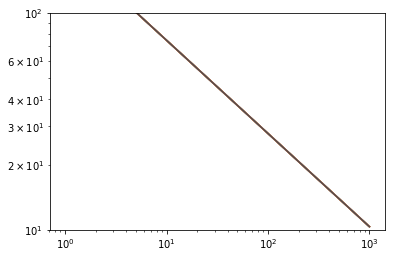

In [7]:
for i,t in enumerate(t_array):
    plt.loglog(a_array, temp_arr[i])
plt.ylim(10,100)

In [8]:
t_array = np.linspace(0.001, 1, 1000) * 3.154e13
a_PF_arr = (3/16)**(1/3) * (fn.G * m_star * fn.m_sun)**(1/3) * (eps_d * f_d)**(2/3) * t_array**(2/3) / fn.au
print(t_array.size, a_PF_arr.size)
print(t_transition(a_array, t_array, a_PF_arr, params) / 3.154e13)

1000 1000
0.001


# Exploring the controlling parameters in Flow Isolation Mass

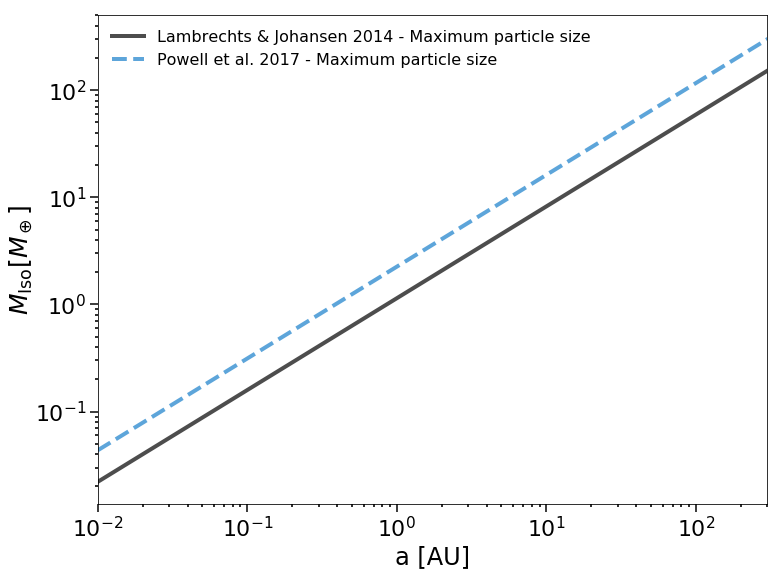

In [92]:
def flow_iso_LJ14(M_star, T_0, f_d, a, t_disk):
    eps_p = 0.5
    temp = T_0*a**(-3./7.)
    c_s = fn.sound_speed(temp)
    v_k = np.sqrt(fn.G * M_star * fn.m_sun/(a * fn.au))
    om = np.sqrt(fn.G * M_star * fn.m_sun/(a * fn.au)**3)
    v_0 = fn.eta(c_s, v_k) * v_k
    H = c_s/om
    St = np.sqrt(3)/8 * eps_p/eta * f_d

    term1 = np.sqrt(St)
    term2 = 1/np.sqrt(3)
    term3 = (c_s/v_0) * St
    min1 = np.minimum(term1, term2)
    pre_fac = np.minimum(min1, term3)
    return M_star * fn.m_sun * (H/(a*fn.au))**3 * pre_fac

def flow_iso_Pow(M_star, T_0, f_d, a, t_disk):
    temp = T_0*a**(-3./7.)
    c_s = fn.sound_speed(temp)
    v_k = np.sqrt(fn.G * M_star * fn.m_sun/(a * fn.au))
    om = np.sqrt(fn.G * M_star * fn.m_sun/(a * fn.au)**3)
    v_0 = fn.eta(c_s, v_k) * v_k
    H = c_s/om
    St = (a * fn.au)/(2 * t_disk * v_0)

    term1 = np.sqrt(St)
    term2 = 1/np.sqrt(3)
    term3 = (c_s/v_0) * St
    min1 = np.minimum(term1, term2)
    pre_fac = np.minimum(min1, term3)
    return M_star * fn.m_sun * (H/(a*fn.au))**3 * pre_fac

params = 121, 0.8, 315, 20, 1.6, 1e-4, f_d, eps_p, eps_d, delt, Lamb # DR Tau params

M_star = 0.8
T_0 = 121
f_d = 1e-2
t_disk = 3.154e7

a_arr = np.logspace(-2, 2.5, 300)
flow_iso_LJ14_arr = flow_iso_LJ14(M_star, T_0, f_d, a_arr, t_disk)
flow_iso_Pow_arr = flow_iso_Pow(M_star, T_0, f_d, a_arr, t_disk)

fig = plt.figure(1,figsize=(12,9))
ax = plt.gca()
ax.tick_params(which='major', length=7,width=2.0)
ax.tick_params(which='minor', length=3.0,width=1.6)     
ax.set_xlabel('a [AU]',fontsize=24)
ax.set_ylabel(r'$M_\mathrm{Iso} \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
plt.loglog(a_arr, flow_iso_LJ14_arr/fn.m_earth, '-', linewidth=4, label='Lambrechts & Johansen 2014 - Maximum particle size')
plt.loglog(a_arr, flow_iso_Pow_arr/fn.m_earth, '--', linewidth=4, label='Powell et al. 2017 - Maximum particle size')
#plt.text(4.1,100,' Powell et al. 2017 - Maximum particle size', backgroundcolor='white', rotation=34.5)
#plt.text(4.3,116," Lambrechts & Johansen 2014 - Maximum particle size", backgroundcolor='white', rotation=34.5)
plt.xlim(1e-2,3e2)
plt.tick_params(axis='both', which='major', labelsize=22, length=8, width=1.5)
plt.legend(frameon=False, fontsize=16)
plt.savefig("Flow_iso_dist.pdf")

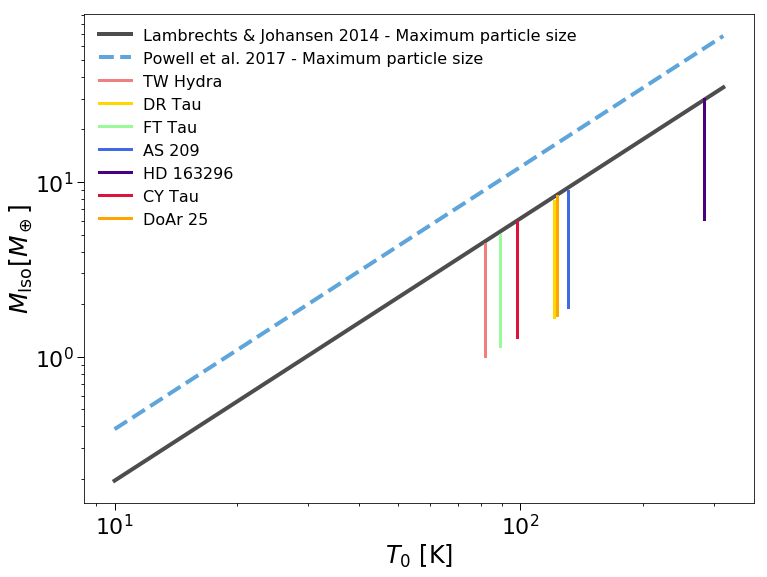

In [93]:
T_0_arr = np.logspace(1, 2.5, 300)
flow_iso_LJ14_arr = flow_iso_LJ14(M_star, T_0_arr, f_d, 10, t_disk)
flow_iso_Pow_arr = flow_iso_Pow(M_star, T_0_arr, f_d, 10, t_disk)

fig = plt.figure(1,figsize=(12,9))
ax = plt.gca()
ax.tick_params(which='major', labelsize=22, length=7,width=1.0)
ax.tick_params(which='minor', length=3.0,width=0.85)     
ax.set_xlabel(r'$T_{0}$ [K]',fontsize=24)
ax.set_ylabel(r'$M_\mathrm{Iso} \left[ M_\oplus \right]$',fontsize=25,labelpad=0.03)
plt.loglog(T_0_arr, flow_iso_LJ14_arr/ fn.m_earth, '-', linewidth=4, label='Lambrechts & Johansen 2014 - Maximum particle size')
plt.loglog(T_0_arr, flow_iso_Pow_arr/fn.m_earth, '--', linewidth=4, label='Powell et al. 2017 - Maximum particle size')
plt.axvline(x=82, ymin=0.3, ymax = 0.53, linewidth=3, color='lightcoral', label='TW Hydra')
plt.axvline(x=121, ymin=0.38, ymax = 0.618, linewidth=3, color='gold', label='DR Tau')
plt.axvline(x=89, ymin=0.32, ymax = 0.548, linewidth=3, color='palegreen', label='FT Tau')
plt.axvline(x=131, ymin=0.4, ymax = 0.638, linewidth=3, color='royalblue', label='AS 209')
plt.axvline(x=284, ymin=0.58, ymax = 0.825, linewidth=3, color='indigo', label='HD 163296')
plt.axvline(x=98, ymin=0.34, ymax = 0.575, linewidth=3, color='crimson', label='CY Tau')
plt.axvline(x=123, ymin=0.385, ymax = 0.627, linewidth=3, color='orange', label='DoAr 25')
plt.legend(frameon=False, fontsize=16, loc=2)
plt.savefig("Flow_iso_temp.pdf")